In [1]:
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

# Read Data

Let's first read in the meta data of all models in the dataset.

In [4]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]


revision_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  5ed1535c95a342f4a414dd8c9b1b7df8   
1ba744cbcafb46c2a52482e36498a9bf  301bfb5af53c431a830a6e435de6a590   
1ba7587b3191422fb03a0e9ba92cebff  ac3baa3e59ca476396b4affa8e900c6f   
1ba758f87e744ff0bcb3119887cac8cc  da11513a93224fbbb2c34ef9c5cfcaa9   
1ba77121c3be44d6bd0b354727f9707b  70d06e82d8c344edab8b041f8b03161a   

                                                   organization_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  6c96d0b6e5e14eeaa9848f953a94e5f8   
1ba744cbcafb46c2a52482e36498a9bf  8af3fc1bb4b74e7c8c4089e4921d9056   
1ba7587b3191422fb03a0e9ba92cebff  36fbc1ee23334e1ab987b07d2108eef2   
1ba758f87e744ff0bcb3119887cac8cc  574093f96e5e4ff09a8b1f24eeb70284   
1ba77121c3be44d6bd0b354727f9707b  ff66cd6b779c44bba88ade8952d7e626   

                                             datetime description  \
model_id                                                            
1ba74449e9354d0c9d4798b4a6e915d0  2019-03-19 11:36:50         NaN   
1ba744cbcafb46c2a52482e36498a9bf  2020-03-23 17:26:03         NaN   
1ba7587b3191422fb03a0e9ba92cebff  2017-04-19 06:19:36         NaN   
1ba758f87e744ff0bcb3119887cac8cc  2021-02-21 13:14:32         NaN   
1ba77121c3be44d6bd0b354727f9707b  2020-06-30 07:12:48         NaN   

                                                                    name type  \
model_id                                                                        
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo  NaN   
1ba744cbcafb46c2a52482e36498a9bf                  Receipt of Application  NaN   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room  NaN   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p  NaN   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen   NaN   

                                                            namespace  
model_id                                                               
1ba74449e9354d0c9d4798b4a6e915d0  http://b3mn.org/stencilset/bpmn2.0#  
1ba744cbcafb46c2a52482e36498a9bf  http://b3mn.org/stencilset/bpmn2.0#  
1ba7587b3191422fb03a0e9ba92cebff  http://b3mn.org/stencilset/bpmn2.0#  
1ba758f87e744ff0bcb3119887cac8cc  http://b3mn.org/stencilset/bpmn2.0#  
1ba77121c3be44d6bd0b354727f9707b  http://b3mn.org/stencilset/bpmn2.0#

# Filtering example processes

The dataset includes the following vendor provided example processes.

In [5]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [6]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [7]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

9991

This is the percentage of example process from the dataset:

In [8]:
len(df_meta_examples)/len(df_meta)

0.4653253225280611

This is the number of models in the dataset without example processes (again, based on process names):

In [9]:
len(df_meta)-len(df_meta_examples)

11480

And the percentage of models in the dataset without example processes:

In [10]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.5346746774719389

We apply the filter to perform the analysis on the dataset without examples processes:

In [11]:
df_meta = df_meta[~df_meta["name"].isin(example_names)]
len(df_meta)

11480

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [12]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)
df_notations

Notation  Frequency
0                 http://b3mn.org/stencilset/bpmn2.0#       8387
1                     http://b3mn.org/stencilset/epc#        685
2     http://www.signavio.com/stencilsets/processmap#        499
3                 http://b3mn.org/stencilset/bpmn1.1#        333
4             http://b3mn.org/stencilset/UML2.2Class#        311
5            http://signavio.com/stencilsets/dmn-1.0#        277
6                http://b3mn.org/stencilset/petrinet#        239
7          http://cisco.com/stencilset/archimate-2.1#        235
8              http://b3mn.org/stencilset/UMLUseCase#        202
9     http://b3mn.org/stencilset/bpmn2.0choreography#         93
10    http://www.signavio.com/stencilsets/organigram#         88
11    http://b3mn.org/stencilset/bpmn2.0conversation#         57
12  http://www.fmc-modeling.org/stencilsets/fmcblo...         28
13          http://signavio.com/stencilsets/cmmn-1.0#         18
14    http://www.signavio.com/stencilsets/journeymap#         11
15                http://b3mn.org/stencilset/yawl2.2#          7
16        http://b3mn.org/stencilset/coloredpetrinet#          5
17                  http://b3mn.org/stencilset/jbpm4#          2
18                 http://b3mn.org/stencilset/xforms#          2
19  http://www.signavio.com/stencilsets/processdoc...          1

We map the namespaces to the common names for the modeling notations.

In [13]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
df_notations = df_notations.replace({'Notation' : d_namespaces})
df_notations

Notation  Frequency
0                         BPMN 2.0       8387
1                              EPC        685
2                      Value Chain        499
3                         BPMN 1.1        333
4                    UML 2.2 Class        311
5                          DMN 1.0        277
6                        Petri Net        239
7                    ArchiMate 2.1        235
8                     UML Use Case        202
9            BPMN 2.0 Choreography         93
10                      Organigram         88
11           BPMN 2.0 Conversation         57
12               FMC Block Diagram         28
13                        CMMN 1.0         18
14                     Journey Map         11
15                        YAWL 2.2          7
16                             CPN          5
17                          jBPM 4          2
18                          XForms          2
19  Process Documentation Template          1

And we aggregate modeling notations which are used for less than 100 models in "Other".

In [14]:
other_dict={
 'Process Documentation Template':'Other',
 'jBPM 4':'Other',
 'XForms':'Other',
 'Chen Notation':'Other'
}
last_x = len(other_dict)
df_notations_upper = df_notations.iloc[:-last_x,:]
df_notations_other = df_notations.iloc[len(df_notations)-last_x:,:].replace({'Notation': other_dict}).groupby('Notation').sum().reset_index()
df_notations=pd.concat([df_notations_upper,df_notations_other],ignore_index=True)
df_notations.tail()

Notation  Frequency
13     CMMN 1.0         18
14  Journey Map         11
15     YAWL 2.2          7
16          CPN          5
17        Other          5

Now we visualize the number of models in different modeling notations.

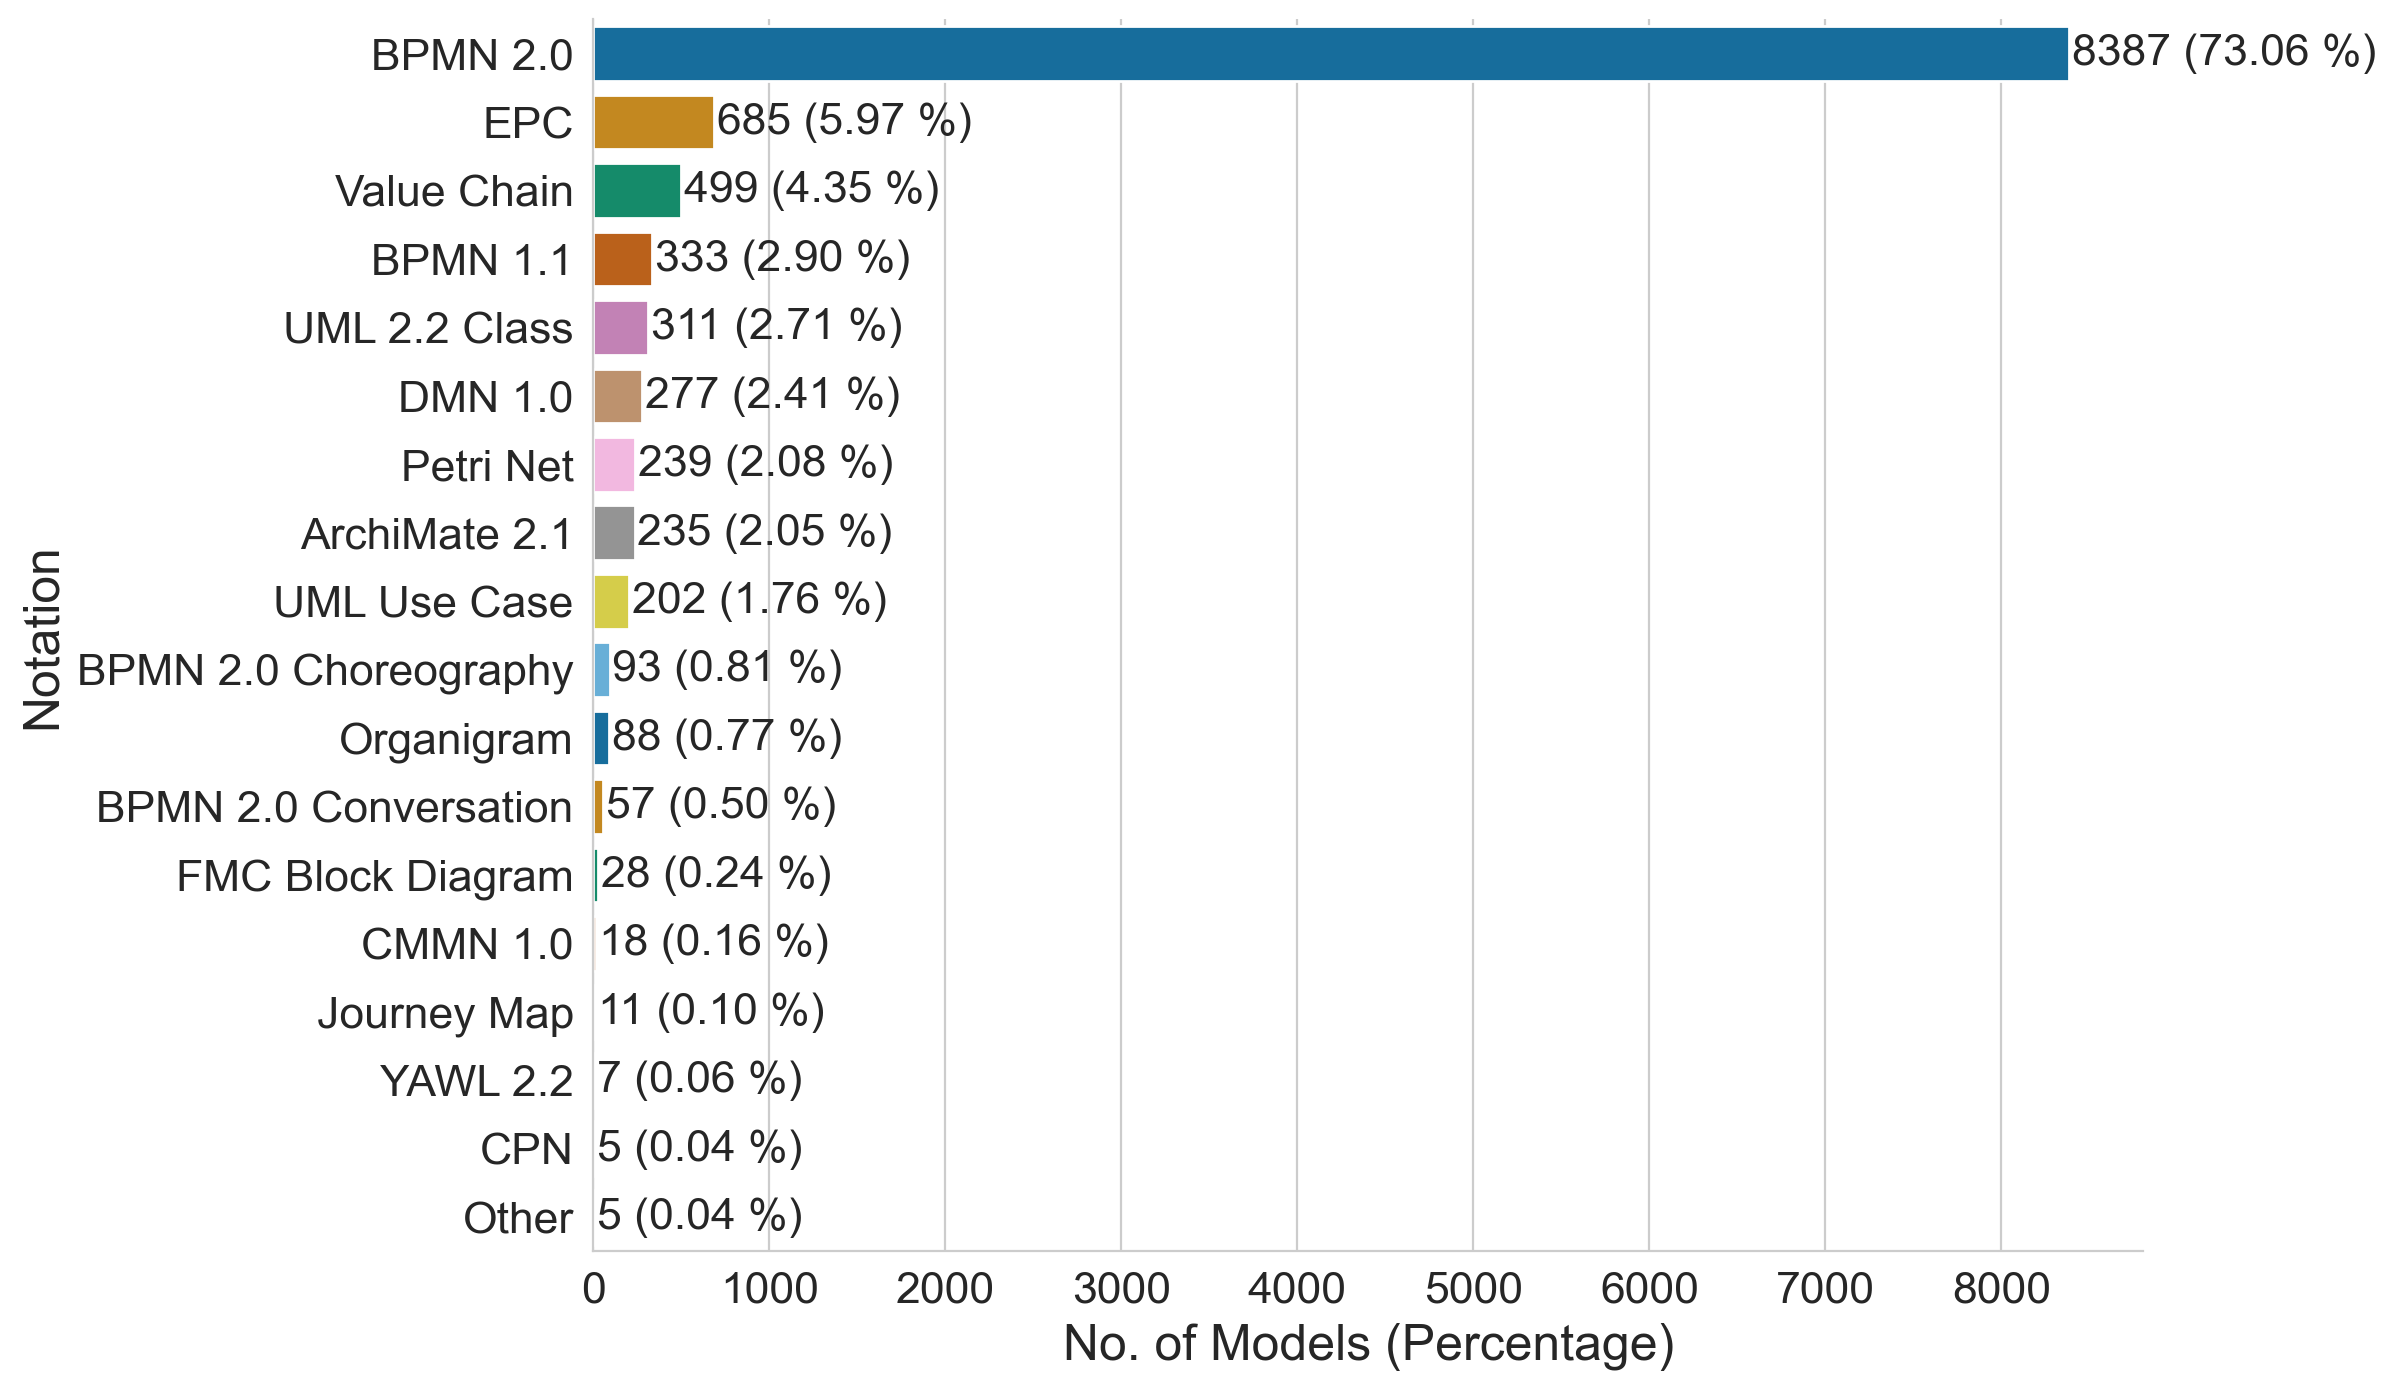

In [15]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
ax=sns.barplot(x="Frequency", y="Notation", data=df_notations, estimator = np.max,ci = 0, palette = sns.color_palette("colorblind"))
# ax=sns.barplot(x="Frequency", y="Notation", hue="Notation", data=df_notations, estimator = np.max, errorbar=('ci', 0), legend=False)
sns.despine()
ax.bar_label(ax.containers[0], label_type='edge', padding=1, labels=[f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
# ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

By using the datetime column, we can also consider the creation of models in different notations over time.

In [16]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [17]:
df_meta.sort_values('datetime').head(1)

revision_id  \
model_id                                                             
644a4899917b42c687b2cabc9f8742cd  ef38dd22174d40ba894df30e5ccf4a1b   

                                                   organization_id  \
model_id                                                             
644a4899917b42c687b2cabc9f8742cd  c78f482cc9d54a278154a3d1671450db   

                                            datetime description  \
model_id                                                           
644a4899917b42c687b2cabc9f8742cd 2011-12-02 14:31:23         NaN   

                                                     name       type  \
model_id                                                               
644a4899917b42c687b2cabc9f8742cd  Aufgabe - 4 Philosophen  Petrinets   

                                                             namespace  
model_id                                                                
644a4899917b42c687b2cabc9f8742cd  http://b3mn.org/stencilset/petrinet#

In [18]:
df_meta.sort_values('datetime').tail(1)

revision_id  \
model_id                                                             
c32c4d43c1a3473d8db670c3739bbb97  b72919cca2154cb5aba499254e0bd2b1   

                                                   organization_id  \
model_id                                                             
c32c4d43c1a3473d8db670c3739bbb97  8f45cdba3d7c4c1b814f1ab1a883e289   

                                            datetime description  \
model_id                                                           
c32c4d43c1a3473d8db670c3739bbb97 2021-09-22 02:56:10         NaN   

                                            name type  \
model_id                                                
c32c4d43c1a3473d8db670c3739bbb97  LABORATORIO 6B  NaN   

                                                            namespace  
model_id                                                               
c32c4d43c1a3473d8db670c3739bbb97  http://b3mn.org/stencilset/bpmn2.0#

Let's check the creation of models over time for the five most used notations.

In [19]:
selected_notations = [d_namespaces_reverse[i] for i in df_notations.Notation.values[:5]]
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations) ].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [20]:
df_meta_selected=df_meta_selected.groupby('namespace').resample('Y').sum().reset_index()
df_meta_selected['Year']= df_meta_selected['datetime'].apply(lambda x:x.year)
df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected

namespace   datetime  Count  Year
0   UML 2.2 Class 2015-12-31      7  2015
1   UML 2.2 Class 2016-12-31     22  2016
2   UML 2.2 Class 2017-12-31     34  2017
3   UML 2.2 Class 2018-12-31     25  2018
4   UML 2.2 Class 2019-12-31     22  2019
5   UML 2.2 Class 2020-12-31     83  2020
6   UML 2.2 Class 2021-12-31    118  2021
7        BPMN 1.1 2015-12-31      4  2015
8        BPMN 1.1 2016-12-31     10  2016
9        BPMN 1.1 2017-12-31     33  2017
10       BPMN 1.1 2018-12-31     47  2018
11       BPMN 1.1 2019-12-31     45  2019
12       BPMN 1.1 2020-12-31     84  2020
13       BPMN 1.1 2021-12-31    110  2021
14       BPMN 2.0 2015-12-31    103  2015
15       BPMN 2.0 2016-12-31    365  2016
16       BPMN 2.0 2017-12-31    772  2017
17       BPMN 2.0 2018-12-31   1377  2018
18       BPMN 2.0 2019-12-31   1716  2019
19       BPMN 2.0 2020-12-31   1967  2020
20       BPMN 2.0 2021-12-31   2087  2021
21            EPC 2015-12-31     23  2015
22            EPC 2016-12-31     56  2016
23            EPC 2017-12-31     98  2017
24            EPC 2018-12-31    139  2018
25            EPC 2019-12-31    123  2019
26            EPC 2020-12-31    159  2020
27            EPC 2021-12-31     87  2021
28    Value Chain 2015-12-31      6  2015
29    Value Chain 2016-12-31     34  2016
30    Value Chain 2017-12-31     51  2017
31    Value Chain 2018-12-31     92  2018
32    Value Chain 2019-12-31    101  2019
33    Value Chain 2020-12-31    129  2020
34    Value Chain 2021-12-31     86  2021

Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [21]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

1

In [22]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2021]
df_meta_selected.head()

namespace   datetime  Count  Year
0  UML 2.2 Class 2015-12-31      7  2015
1  UML 2.2 Class 2016-12-31     22  2016
2  UML 2.2 Class 2017-12-31     34  2017
3  UML 2.2 Class 2018-12-31     25  2018
4  UML 2.2 Class 2019-12-31     22  2019

In [23]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

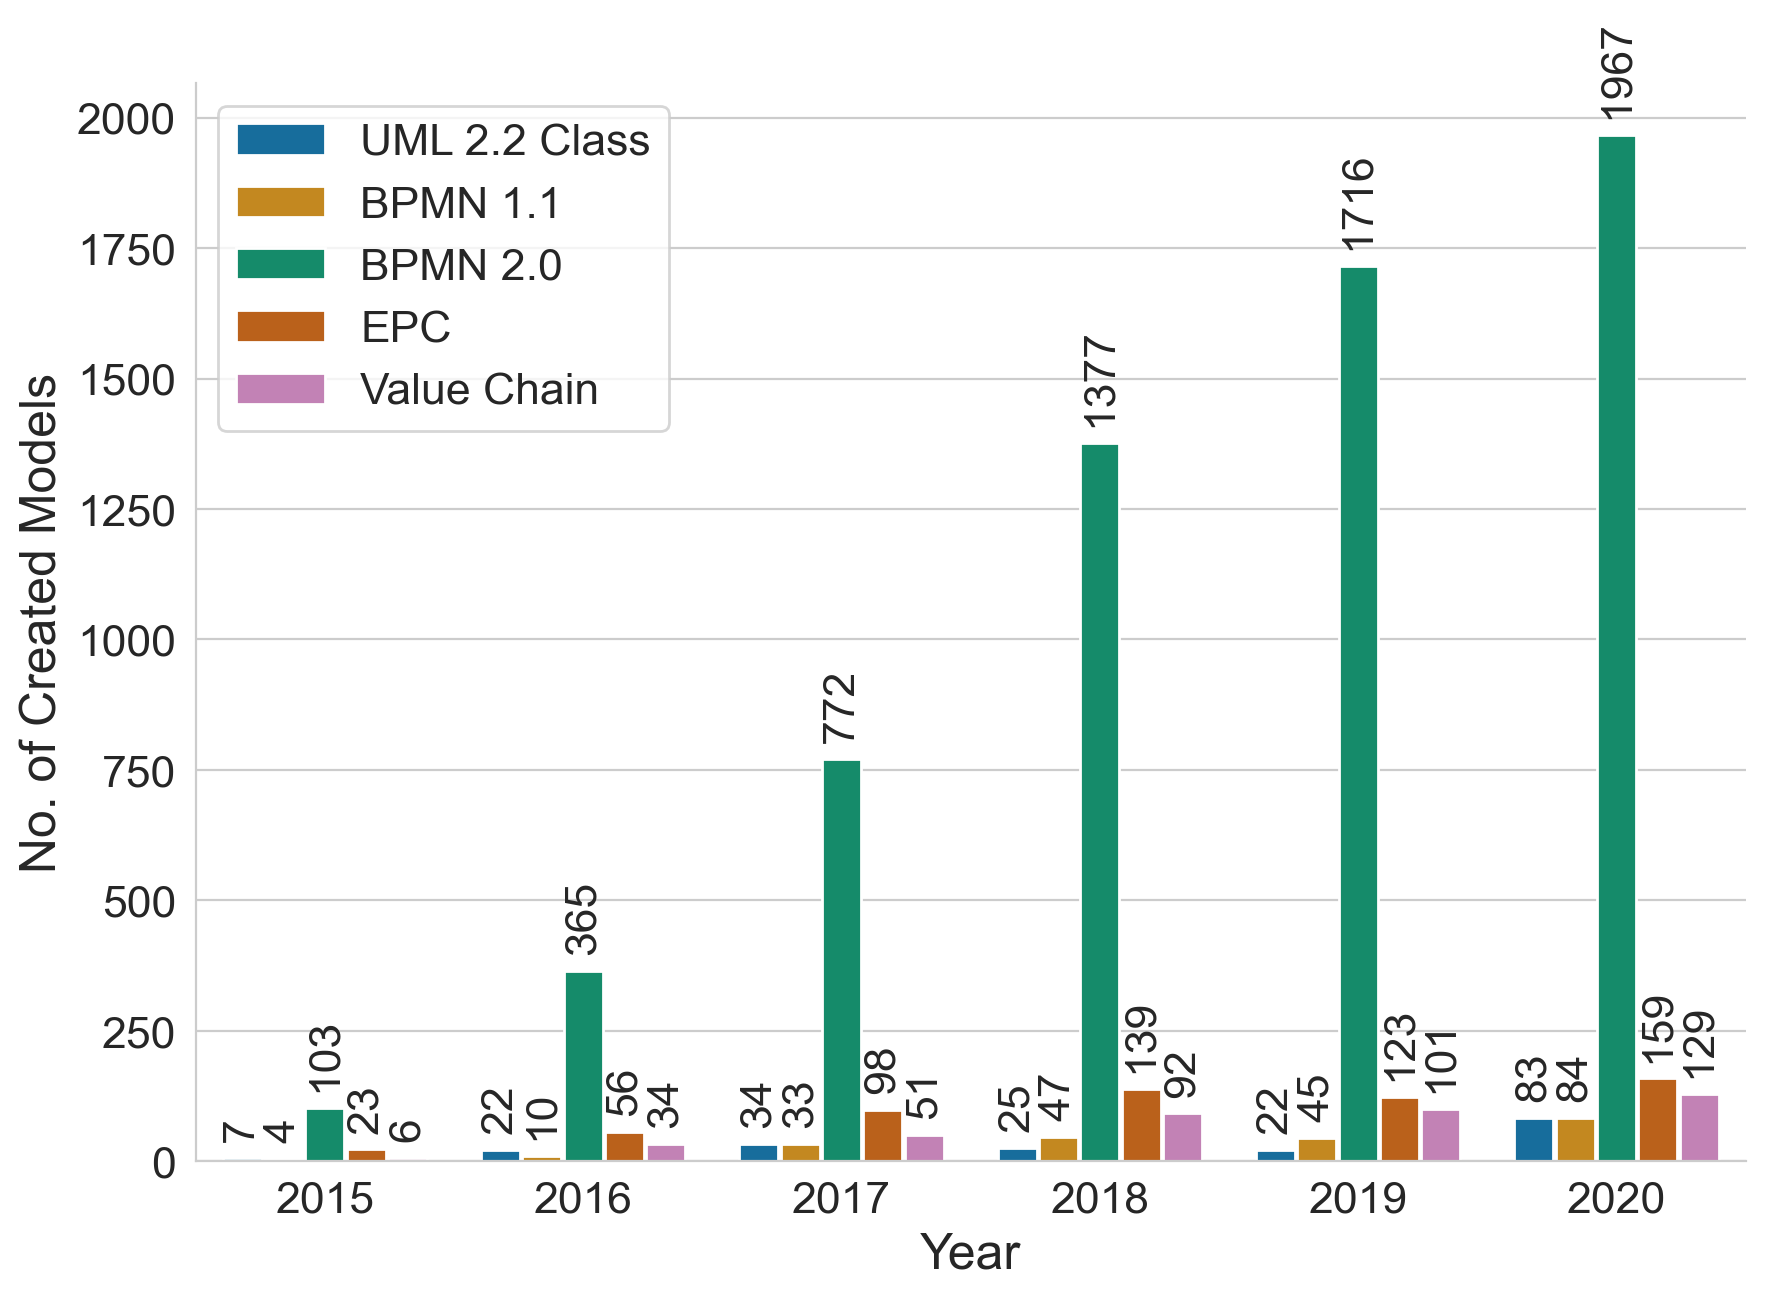

In [24]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax,palette=sns.color_palette("colorblind"))
plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [25]:
selected_notations_short = [d_namespaces[n] for n in selected_notations]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked,index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

BPMN 2.0  EPC  Value Chain  BPMN 1.1  UML 2.2 Class
2020      1967  159          129        84             83
2019      1716  123          101        45             22
2018      1377  139           92        47             25
2017       772   98           51        33             34
2016       365   56           34        10             22
2015       103   23            6         4              7

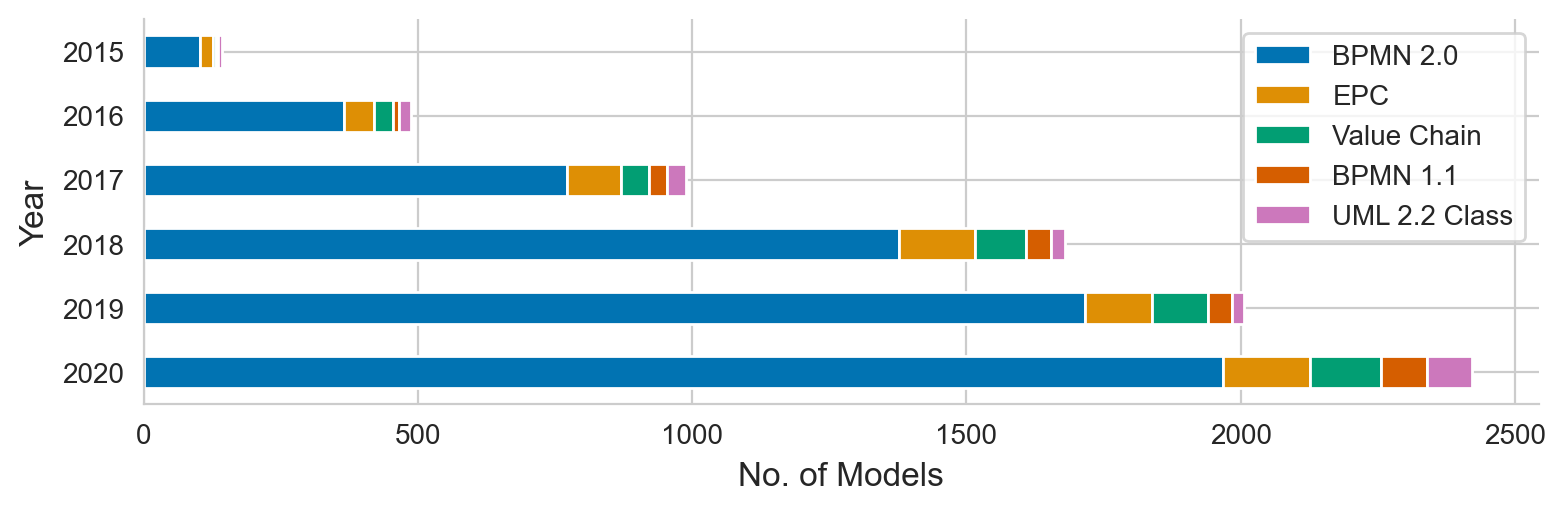

In [26]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [27]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]

Number of BPMN 2.0 models:

In [28]:
len(df_meta_bpmn)

8387

We use the BPMNModelParser to parse the BPMN 2.0 models. In case, we have already parsed them, we load the parsed data from the pkl file.

In [29]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
# df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.47s/it]


category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  
model_id                         element_id                                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                        
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n  
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                        
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n  
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262

Number of BPMN 2.0 models from the parser:

In [30]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

12640

The difference in the number of BPMN 2.0 models shows that there are some empty BPMN 2.0 models in the dataset which do not contain any elements. 

The total number of elements of all BPMN 2.0 models is:

In [31]:
len(df_bpmn)

589816

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [32]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    #!pip install update -U pydantic==1.10.8
    print("\033[92m\u2713\033[0m Download and installation successful")

Installing package...
DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.4.1/en_core_web_sm-3.4.1-py3-none-any.whl#egg=en_core_web_sm==3.4.1 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
✓ Download and installation successful


In [33]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12640/12640 [03:32<00:00, 59.60it/s]


label  \
model_id                                                                              
1ba74449e9354d0c9d4798b4a6e915d0   Konobar\n Narudžba primljena\n Narudžba / kup...   
1ba744cbcafb46c2a52482e36498a9bf   Reject  Accept No Yes Applicant ACME AG Head ...   
1ba7587b3191422fb03a0e9ba92cebff   Yes No Organization\n Employee Meeting confir...   
1ba758f87e744ff0bcb3119887cac8cc   A student visits ACBT Direct to ECU SL Direct...   
1ba77121c3be44d6bd0b354727f9707b   Kunde  "DESADV"\n geht ein Auftrags-\nE-Mail ...   

                                 detected_natural_language  
model_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0                        hr  
1ba744cbcafb46c2a52482e36498a9bf                        en  
1ba7587b3191422fb03a0e9ba92cebff                        en  
1ba758f87e744ff0bcb3119887cac8cc                        en  
1ba77121c3be44d6bd0b354727f9707b                        de

Let's plot the use of different languages across the dataset.

In [34]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [35]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

Language  No. of Models
0                      English           7233
1                       German           3369
2                      Italian            395
3                      Spanish            352
4                       French            207
5                     Croatian            160
6                   Portuguese            147
7                     Estonian            111
8                    Slovenian             88
9   Unknown language [UNKNOWN]             88
10                    Romanian             83
11                       Dutch             81
12                  Indonesian             58
13                     Swedish             49
14                      Polish             35
15                   Hungarian             26
16                       Greek             20
17                      Danish             15
18                     Finnish             12
19                     Catalan             12
20                       Welsh             11
21                   Norwegian             11
22                     Turkish             10
23                   Afrikaans             10
24                  Vietnamese              8
25                    Japanese              8
26                     Tagalog              7
27    Unknown language [zh-cn]              6
28                     Latvian              5
29                    Albanian              5
30                       Czech              4
31                      Slovak              3
32                     Persian              3
33                     Russian              2
34                      Somali              2
35                  Macedonian              2
36                  Lithuanian              2

We only plot the 10 most common languages.

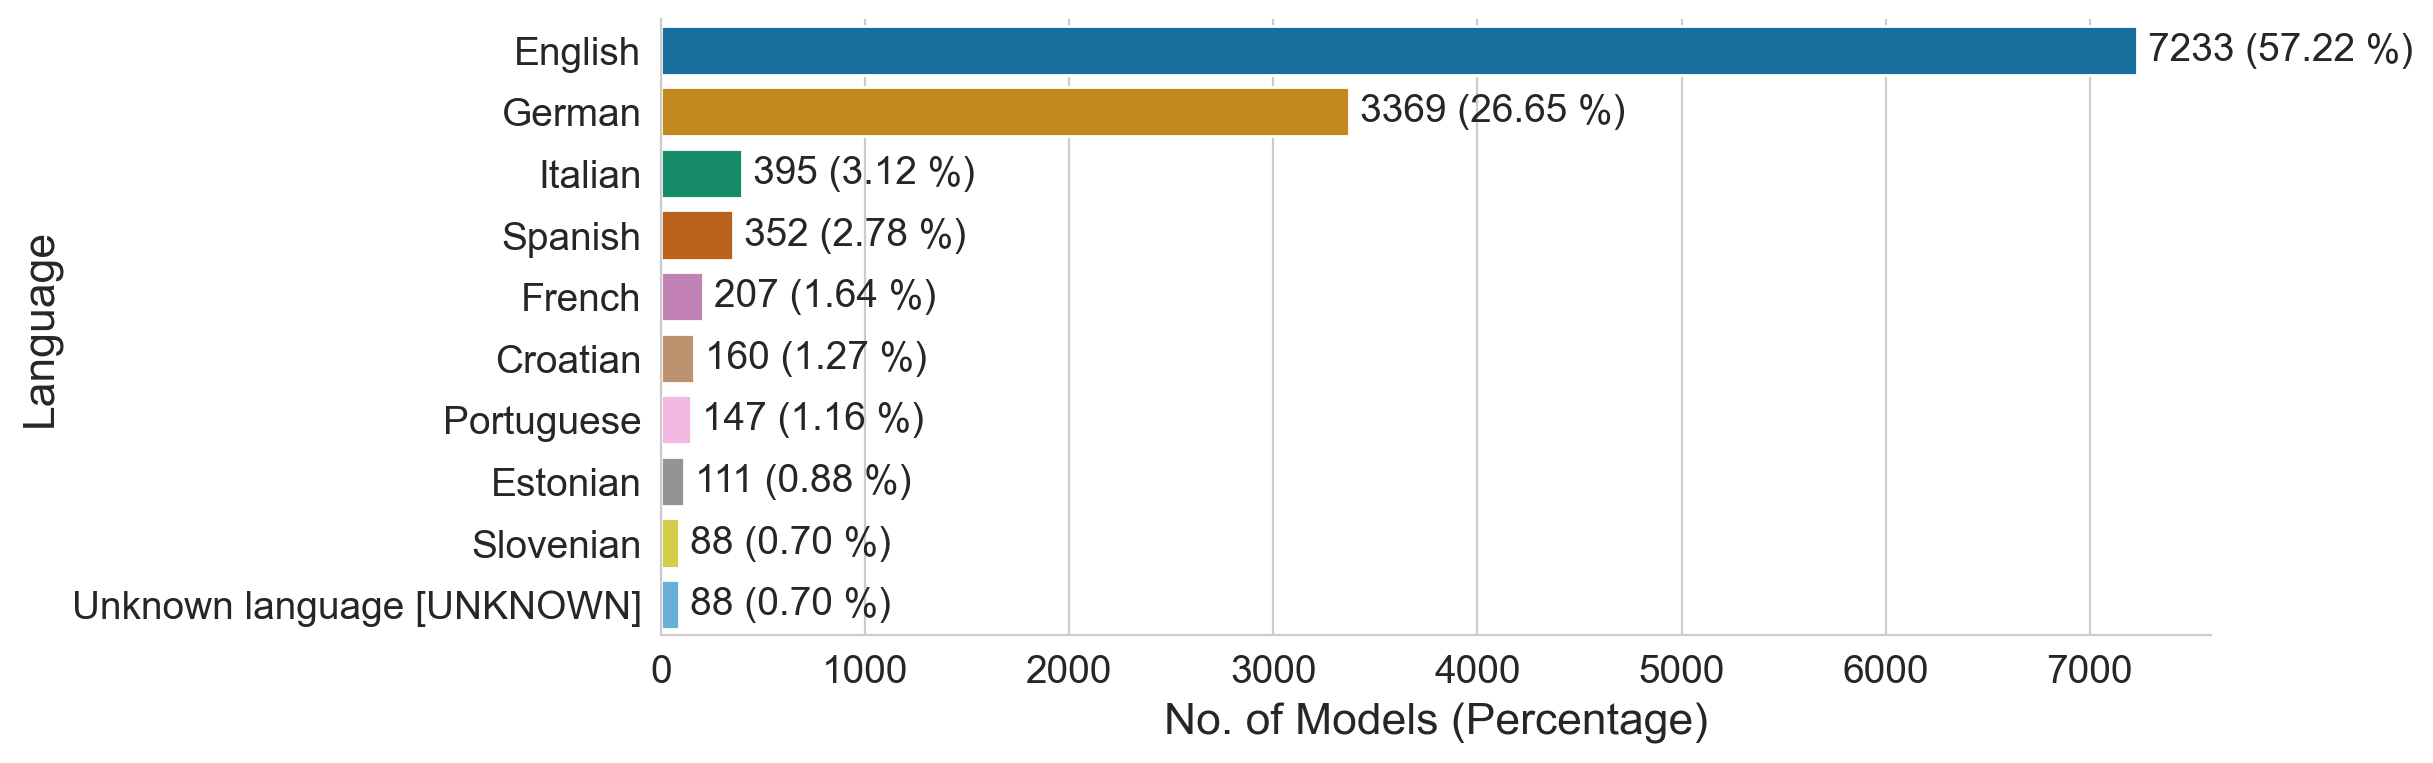

In [36]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:10]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", data=df_lang,palette=sns.color_palette("colorblind"))
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']])
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Now we want to examine the usage of element types in the BPMN models.

In [37]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [38]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0, downcast="infer") # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12640/12640 [00:06<00:00, 1860.19it/s]


MessageFlow  Pool  Lane  StartMessageEvent  SequenceFlow  \
0            1     2     2                  1             2   
1            7     1     2                  1            15   
2            0     1     3                  0            17   
3            0     0     0                  0             6   
4            1     2     5                  0            25   

   EventbasedGateway  Task  StartNoneEvent  total_count  \
0                  1     2               1           12   
1                  0     7               0           47   
2                  0    12               1           38   
3                  0     6               0           13   
4                  0    12               1           66   

   Association_Undirected  Association_Unidirectional  CollapsedPool  \
0                       0                           0              0   
1                       2                           1              1   
2                       0                           0              0   
3                       0                           0              0   
4                       2                           1              0   

   IntermediateMessageEventThrowing  Exclusive_Databased_Gateway  \
0                                 0                            0   
1                                 1                            3   
2                                 0                            2   
3                                 0                            1   
4                                 2                            0   

   EndNoneEvent  processparticipant  IntermediateMessageEventCatching  \
0             0                   0                                 0   
1             2                   2                                 1   
2             2                   0                                 0   
3             0                   0                                 0   
4             4                   0                                 1   

   DataObject  ITSystem  ParallelGateway  StartConditionalEvent  \
0           0         0                0                      0   
1           1         0                0                      0   
2           0         0                0                      0   
3           0         0                0                      0   
4           1         2                3                      3   

   IntermediateConditionalEvent  CollapsedSubprocess  EndEscalationEvent  \
0                             0                    0                   0   
1                             0                    0                   0   
2                             0                    0                   0   
3                             0                    0                   0   
4                             1                    0                   0   

   IntermediateTimerEvent  EndTerminateEvent  TextAnnotation  Subprocess  \
0                       0                  0               0           0   
1                       0                  0               0           0   
2                       0                  0               0           0   
3                       0                  0               0           0   
4                       0                  0               0           0   

   IntermediateEvent  InclusiveGateway  DataStore  EndMessageEvent  \
0                  0                 0          0                0   
1                  0                 0          0                0   
2                  0                 0          0                0   
3                  0                 0          0                0   
4                  0                 0          0                0   

   IntermediateEscalationEvent  EventSubprocess  StartTimerEvent  \
0                            0                0                0   
1                            0                0                0   
2                            0                

These are the statistics of the different element types per model:

In [39]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count    12640.000000
mean        11.299130
std          3.928106
min          1.000000
25%          8.000000
50%         11.000000
75%         14.000000
max         30.000000
dtype: float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [40]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0, downcast="infer")
)
df_cnts.head()

category                          Association_Bidirectional  \
model_id                                                      
1ba74449e9354d0c9d4798b4a6e915d0                          0   
1ba744cbcafb46c2a52482e36498a9bf                          0   
1ba7587b3191422fb03a0e9ba92cebff                          0   
1ba758f87e744ff0bcb3119887cac8cc                          0   
1ba77121c3be44d6bd0b354727f9707b                          0   

category                          Association_Undirected  \
model_id                                                   
1ba74449e9354d0c9d4798b4a6e915d0                       0   
1ba744cbcafb46c2a52482e36498a9bf                       2   
1ba7587b3191422fb03a0e9ba92cebff                       0   
1ba758f87e744ff0bcb3119887cac8cc                       0   
1ba77121c3be44d6bd0b354727f9707b                       2   

category                          Association_Unidirectional  \
model_id                                                       
1ba74449e9354d0c9d4798b4a6e915d0                           0   
1ba744cbcafb46c2a52482e36498a9bf                           1   
1ba7587b3191422fb03a0e9ba92cebff                           0   
1ba758f87e744ff0bcb3119887cac8cc                           0   
1ba77121c3be44d6bd0b354727f9707b                           1   

category                          ChoreographyParticipant  ChoreographyTask  \
model_id                                                                      
1ba74449e9354d0c9d4798b4a6e915d0                        0                 0   
1ba744cbcafb46c2a52482e36498a9bf                        0                 0   
1ba7587b3191422fb03a0e9ba92cebff                        0                 0   
1ba758f87e744ff0bcb3119887cac8cc                        0                 0   
1ba77121c3be44d6bd0b354727f9707b                        0                 0   

category                          CollapsedEventSubprocess  CollapsedPool  \
model_id                                                                    
1ba74449e9354d0c9d4798b4a6e915d0                         0              0   
1ba744cbcafb46c2a52482e36498a9bf                         0              1   
1ba7587b3191422fb03a0e9ba92cebff                         0              0   
1ba758f87e744ff0bcb3119887cac8cc                         0              0   
1ba77121c3be44d6bd0b354727f9707b                         0              0   

category                          CollapsedSubprocess  CollapsedVerticalPool  \
model_id                                                                       
1ba74449e9354d0c9d4798b4a6e915d0                    0                      0   
1ba744cbcafb46c2a52482e36498a9bf                    0                      0   
1ba7587b3191422fb03a0e9ba92cebff                    0                      0   
1ba758f87e744ff0bcb3119887cac8cc                    0                      0   
1ba77121c3be44d6bd0b354727f9707b                    0                      0   

category                          ComplexGateway  DataObject  DataStore  \
model_id                                                                  
1ba74449e9354d0c9d4798b4a6e915d0               0           0          0   
1ba744cbcafb46c2a52482e36498a9bf               0           1          0   
1ba7587b3191422fb03a0e9ba92cebff               0           0          0   
1ba758f87e744ff0bcb3119887cac8cc               0           0          0   
1ba77121c3be44d6bd0b354727f9707b               0           1          0   

category                          EndCancelEvent  EndCompensationEvent  \
model_id                                                                 
1ba74449e9354d0c9d4798b4a6e915d0               0                     0   
1ba744cbcafb46c2a52482e36498a9bf               0                     0   
1ba7587b3191422fb03a0e9ba92cebff               0                     0   
1ba758f87e744ff0bcb3119887cac8cc               0                     0   
1ba77121c3be44d6bd0b354727f9707b               0               

In [41]:
# df_cnts.drop(["gdashedline","gdiamond","gdottedline","gellipse","grect","gtext"],axis=1,inplace=True)

In [42]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
len(df_freq[df_freq["frequency"]/len(df_cnts) < 0.1])

46

In [43]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())
df_freq.head()

category  frequency
0   Sequence flow      12506
1            Task      12411
2  End none event      11661
3            Lane      10489
4            Pool      10482

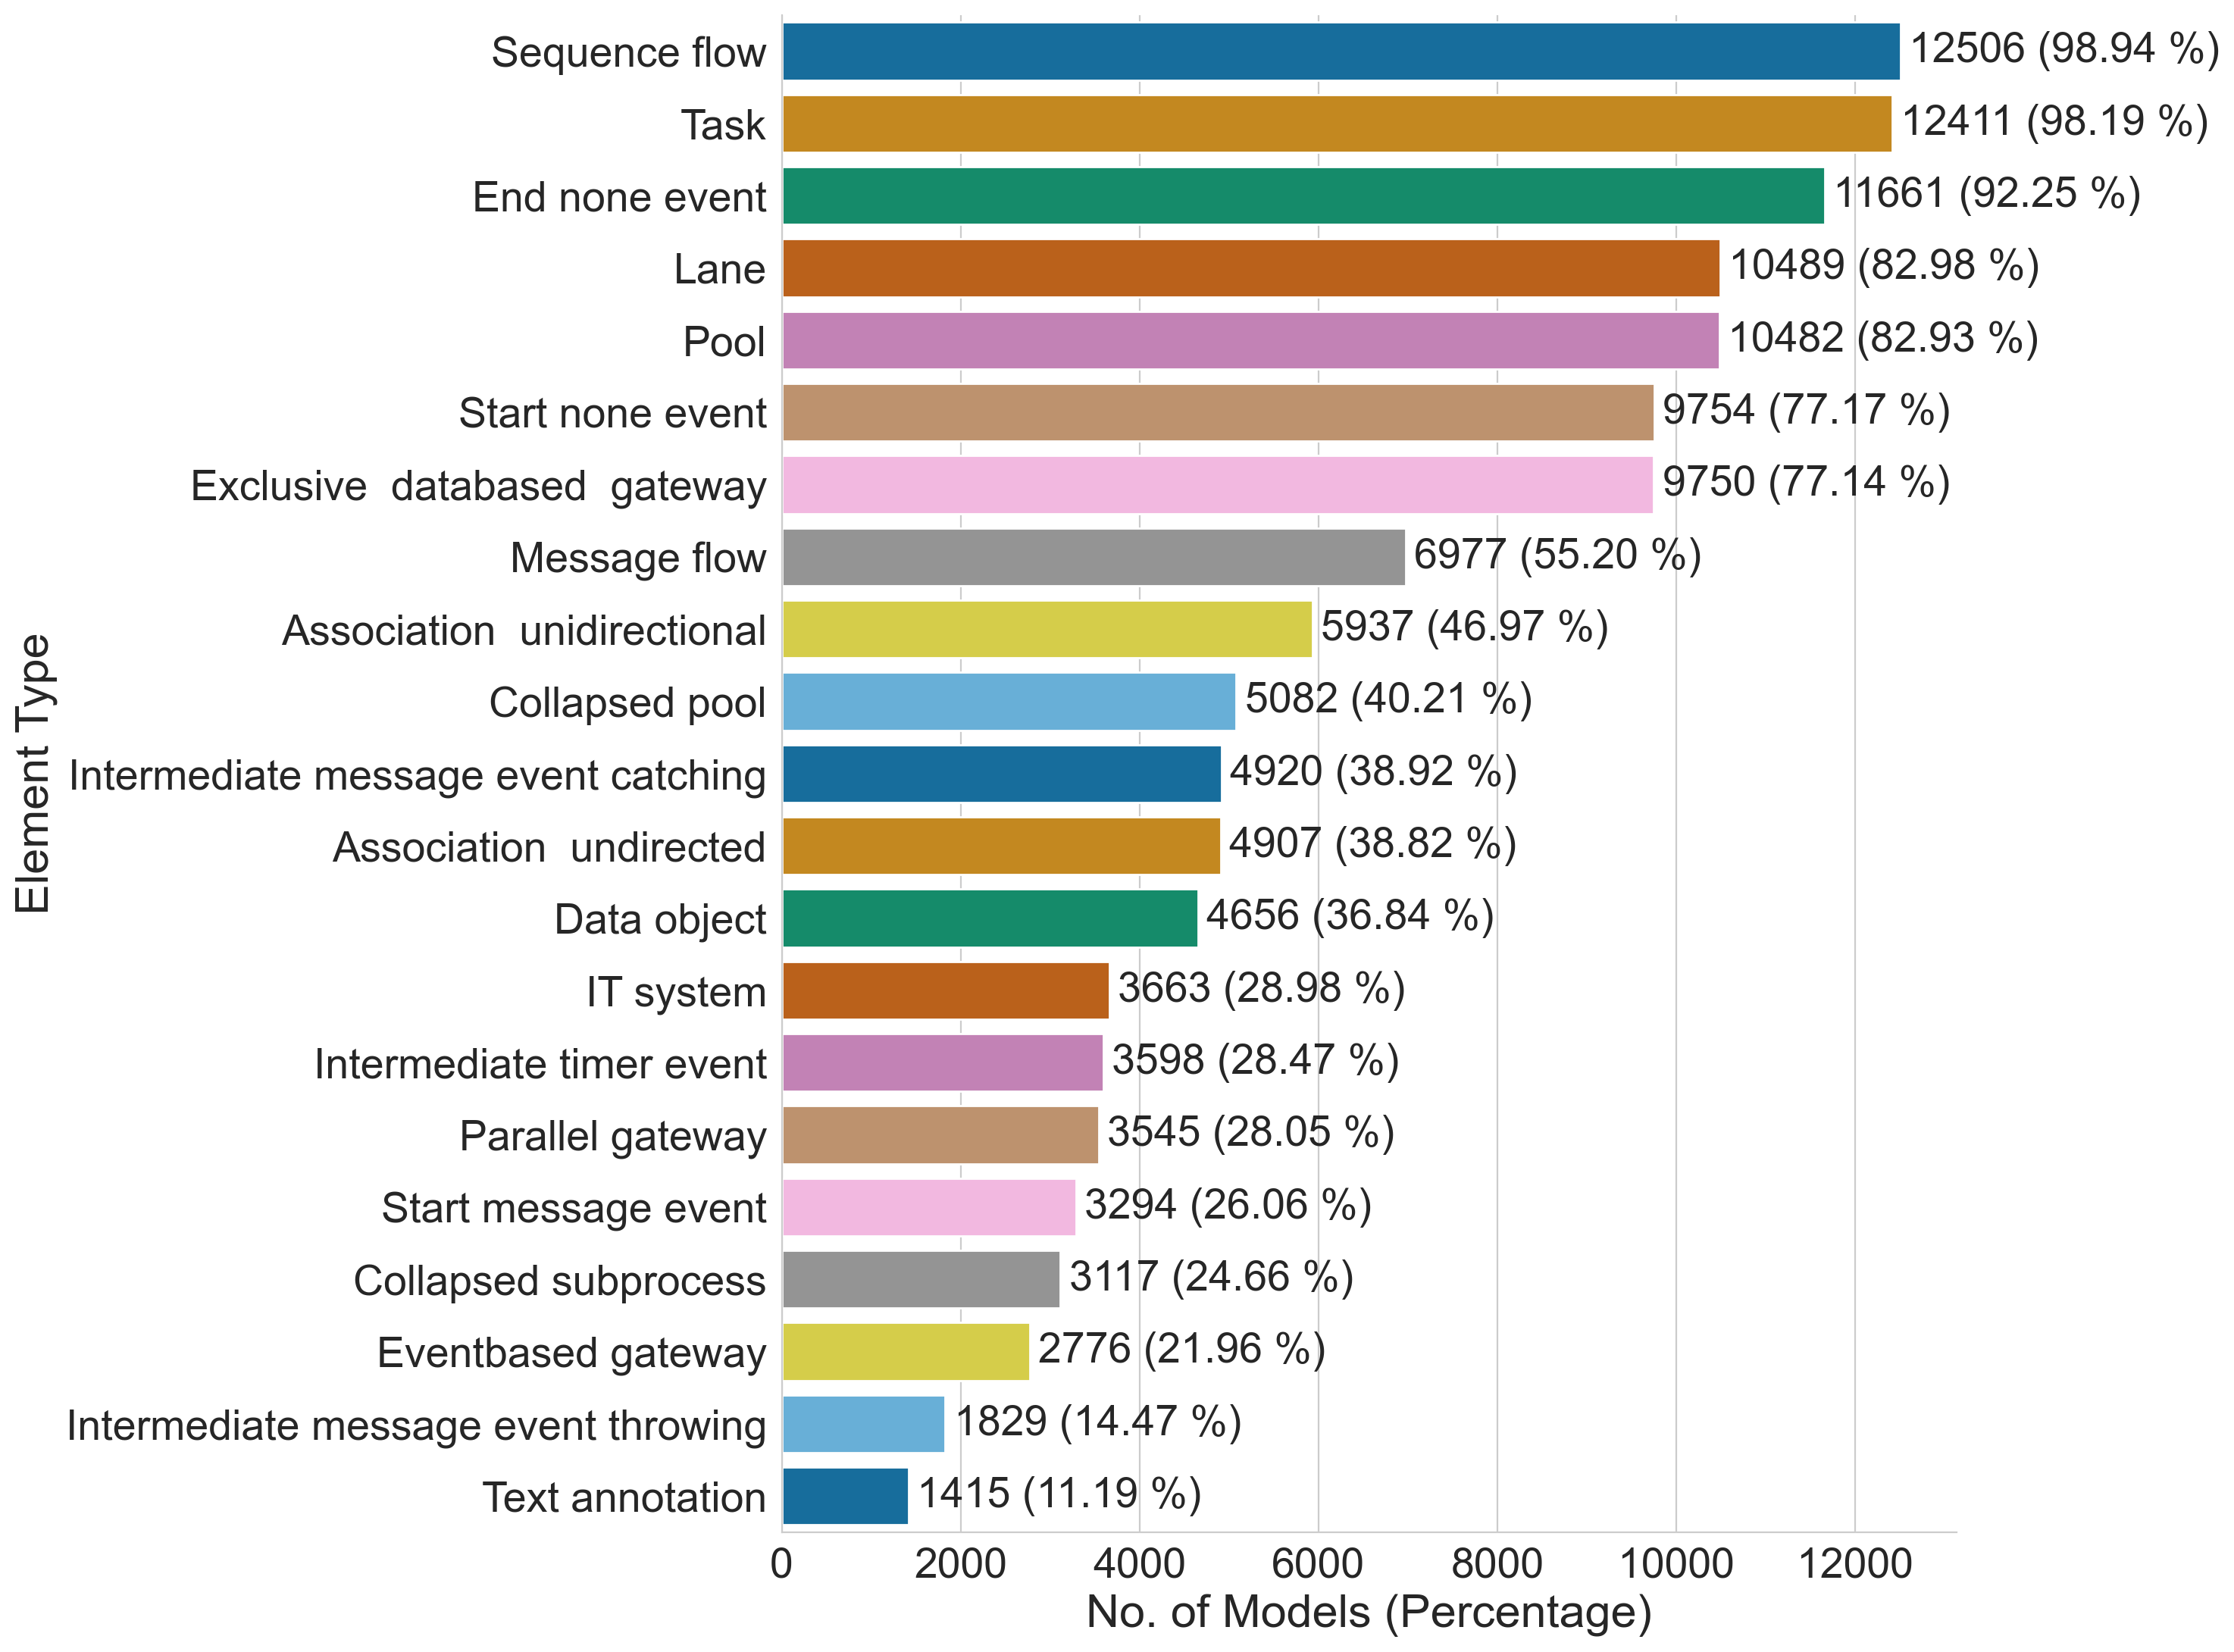

In [44]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
ax = sns.barplot(x="frequency", y="category", data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind"));
total = len(df_cnts)
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_freq['frequency']])
sns.despine()
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Elements

These are the statistics of the number of elements per model:

In [45]:
cnt_elements.total_count.describe()

count    12640.000000
mean        46.662658
std         40.632360
min          1.000000
25%         30.000000
50%         40.000000
75%         47.000000
max       1333.000000
Name: total_count, dtype: float64

These are the statistics of the number of elements per model by element type:

In [46]:
cnt_elements.describe().transpose()

count       mean        std  min  \
MessageFlow                                12640.0   2.447468   3.532552  0.0   
Pool                                       12640.0   1.110522   0.906875  0.0   
Lane                                       12640.0   2.063687   1.687599  0.0   
StartMessageEvent                          12640.0   0.343908   0.847033  0.0   
SequenceFlow                               12640.0  17.681487  15.693297  0.0   
EventbasedGateway                          12640.0   0.256487   0.576765  0.0   
Task                                       12640.0   8.090744   7.989485  0.0   
StartNoneEvent                             12640.0   0.872943   0.706348  0.0   
total_count                                12640.0  46.662658  40.632360  1.0   
Association_Undirected                     12640.0   1.135127   3.928763  0.0   
Association_Unidirectional                 12640.0   1.810759   3.814134  0.0   
CollapsedPool                              12640.0   0.461709   0.690461  0.0   
IntermediateMessageEventThrowing           12640.0   0.315111   1.194772  0.0   
Exclusive_Databased_Gateway                12640.0   2.648101   3.220302  0.0   
EndNoneEvent                               12640.0   1.778402   1.558834  0.0   
processparticipant                         12640.0   0.173892   0.777980  0.0   
IntermediateMessageEventCatching           12640.0   0.879035   1.758729  0.0   
DataObject                                 12640.0   1.002373   2.746221  0.0   
ITSystem                                   12640.0   0.519778   1.506771  0.0   
ParallelGateway                            12640.0   0.673259   1.388712  0.0   
StartConditionalEvent                      12640.0   0.010601   0.141365  0.0   
IntermediateConditionalEvent               12640.0   0.026187   0.299316  0.0   
CollapsedSubprocess                        12640.0   0.397073   1.081243  0.0   
EndEscalationEvent                         12640.0   0.079826   0.273070  0.0   
IntermediateTimerEvent                     12640.0   0.398180   0.835698  0.0   
EndTerminateEvent                          12640.0   0.058070   0.361246  0.0   
TextAnnotation                             12640.0   0.400000   2.931688  0.0   
Subprocess                                 12640.0   0.063212   0.390010  0.0   
IntermediateEvent                          12640.0   0.049209   0.535280  0.0   
InclusiveGateway                           12640.0   0.114082   0.556592  0.0   
DataStore                                  12640.0   0.188449   0.867844  0.0   
EndMessageEvent                            12640.0   0.157516   0.711228  0.0   
IntermediateEscalationEvent                12640.0   0.077136   0.275570  0.0   
EventSubprocess                            12640.0   0.015348   0.185097  0.0   
StartTimerEvent                            12640.0   0.047547   0.313782  0.0   
IntermediateErrorEvent                     12640.0   0.035997   0.274251  0.0   
IntermediateLinkEventCatching              12640.0   0.012421   0.162816  0.0   
IntermediateLinkEventThrowing              12640.0   0.014873   0.202681  0.0   
Message                                    12640.0   0.073892   0.748392  0.0   
Group                                      12640.0   0.020174   0.396784  0.0   
Association_Bidirectional                  12640.0   0.029035   0.454805  0.0   
EndErrorEvent                              12640.0   0.017722   0.163539  0.0   
IntermediateMultipleEventCatching          12640.0   0.005459   0.095231  0.0   
IntermediateSignalEventThrowing            12640.0   0.007358   0.127144  0.0   
StartMultipleEvent                         12640.0   0.003085   0.058246  0.0   
EndSignalEvent                             12640.0   0.005380   0.115166  0.0   
StartSignalEvent                           12640.0   0.006566   0.111260  0.0   
IntermediateCancelEvent                    12640.0   0.004114   0.073234  0.0   
IntermediateCompensationEventCatching      12640.0   0.009889   0.163475  0.

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [47]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [48]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats.head()

count       mean        std  min   25%   50%   75%  \
Activities          12640.0   8.567722   8.185725  0.0   4.0   7.0   9.0   
Artifacts           12640.0   0.939953   3.423429  0.0   0.0   0.0   1.0   
Connecting Objects  12640.0  23.103877  21.338661  0.0  14.0  20.0  25.0   
Data Elements       12640.0   1.264715   3.227045  0.0   0.0   0.0   2.0   
Events              12640.0   5.256171   5.247453  0.0   2.0   5.0   6.0   

                      max  
Activities          259.0  
Artifacts           155.0  
Connecting Objects  709.0  
Data Elements        98.0  
Events              155.0

In [49]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

mean   std  min   25%   50%   75%    max
Activities           8.6   8.2  0.0   4.0   7.0   9.0  259.0
Artifacts            0.9   3.4  0.0   0.0   0.0   1.0  155.0
Connecting Objects  23.1  21.3  0.0  14.0  20.0  25.0  709.0
Data Elements        1.3   3.2  0.0   0.0   0.0   2.0   98.0
Events               5.3   5.2  0.0   2.0   5.0   6.0  155.0
Gateways             3.7   4.0  0.0   2.0   3.0   4.0  122.0
Swimlanes            3.8   2.7  0.0   3.0   4.0   5.0   61.0

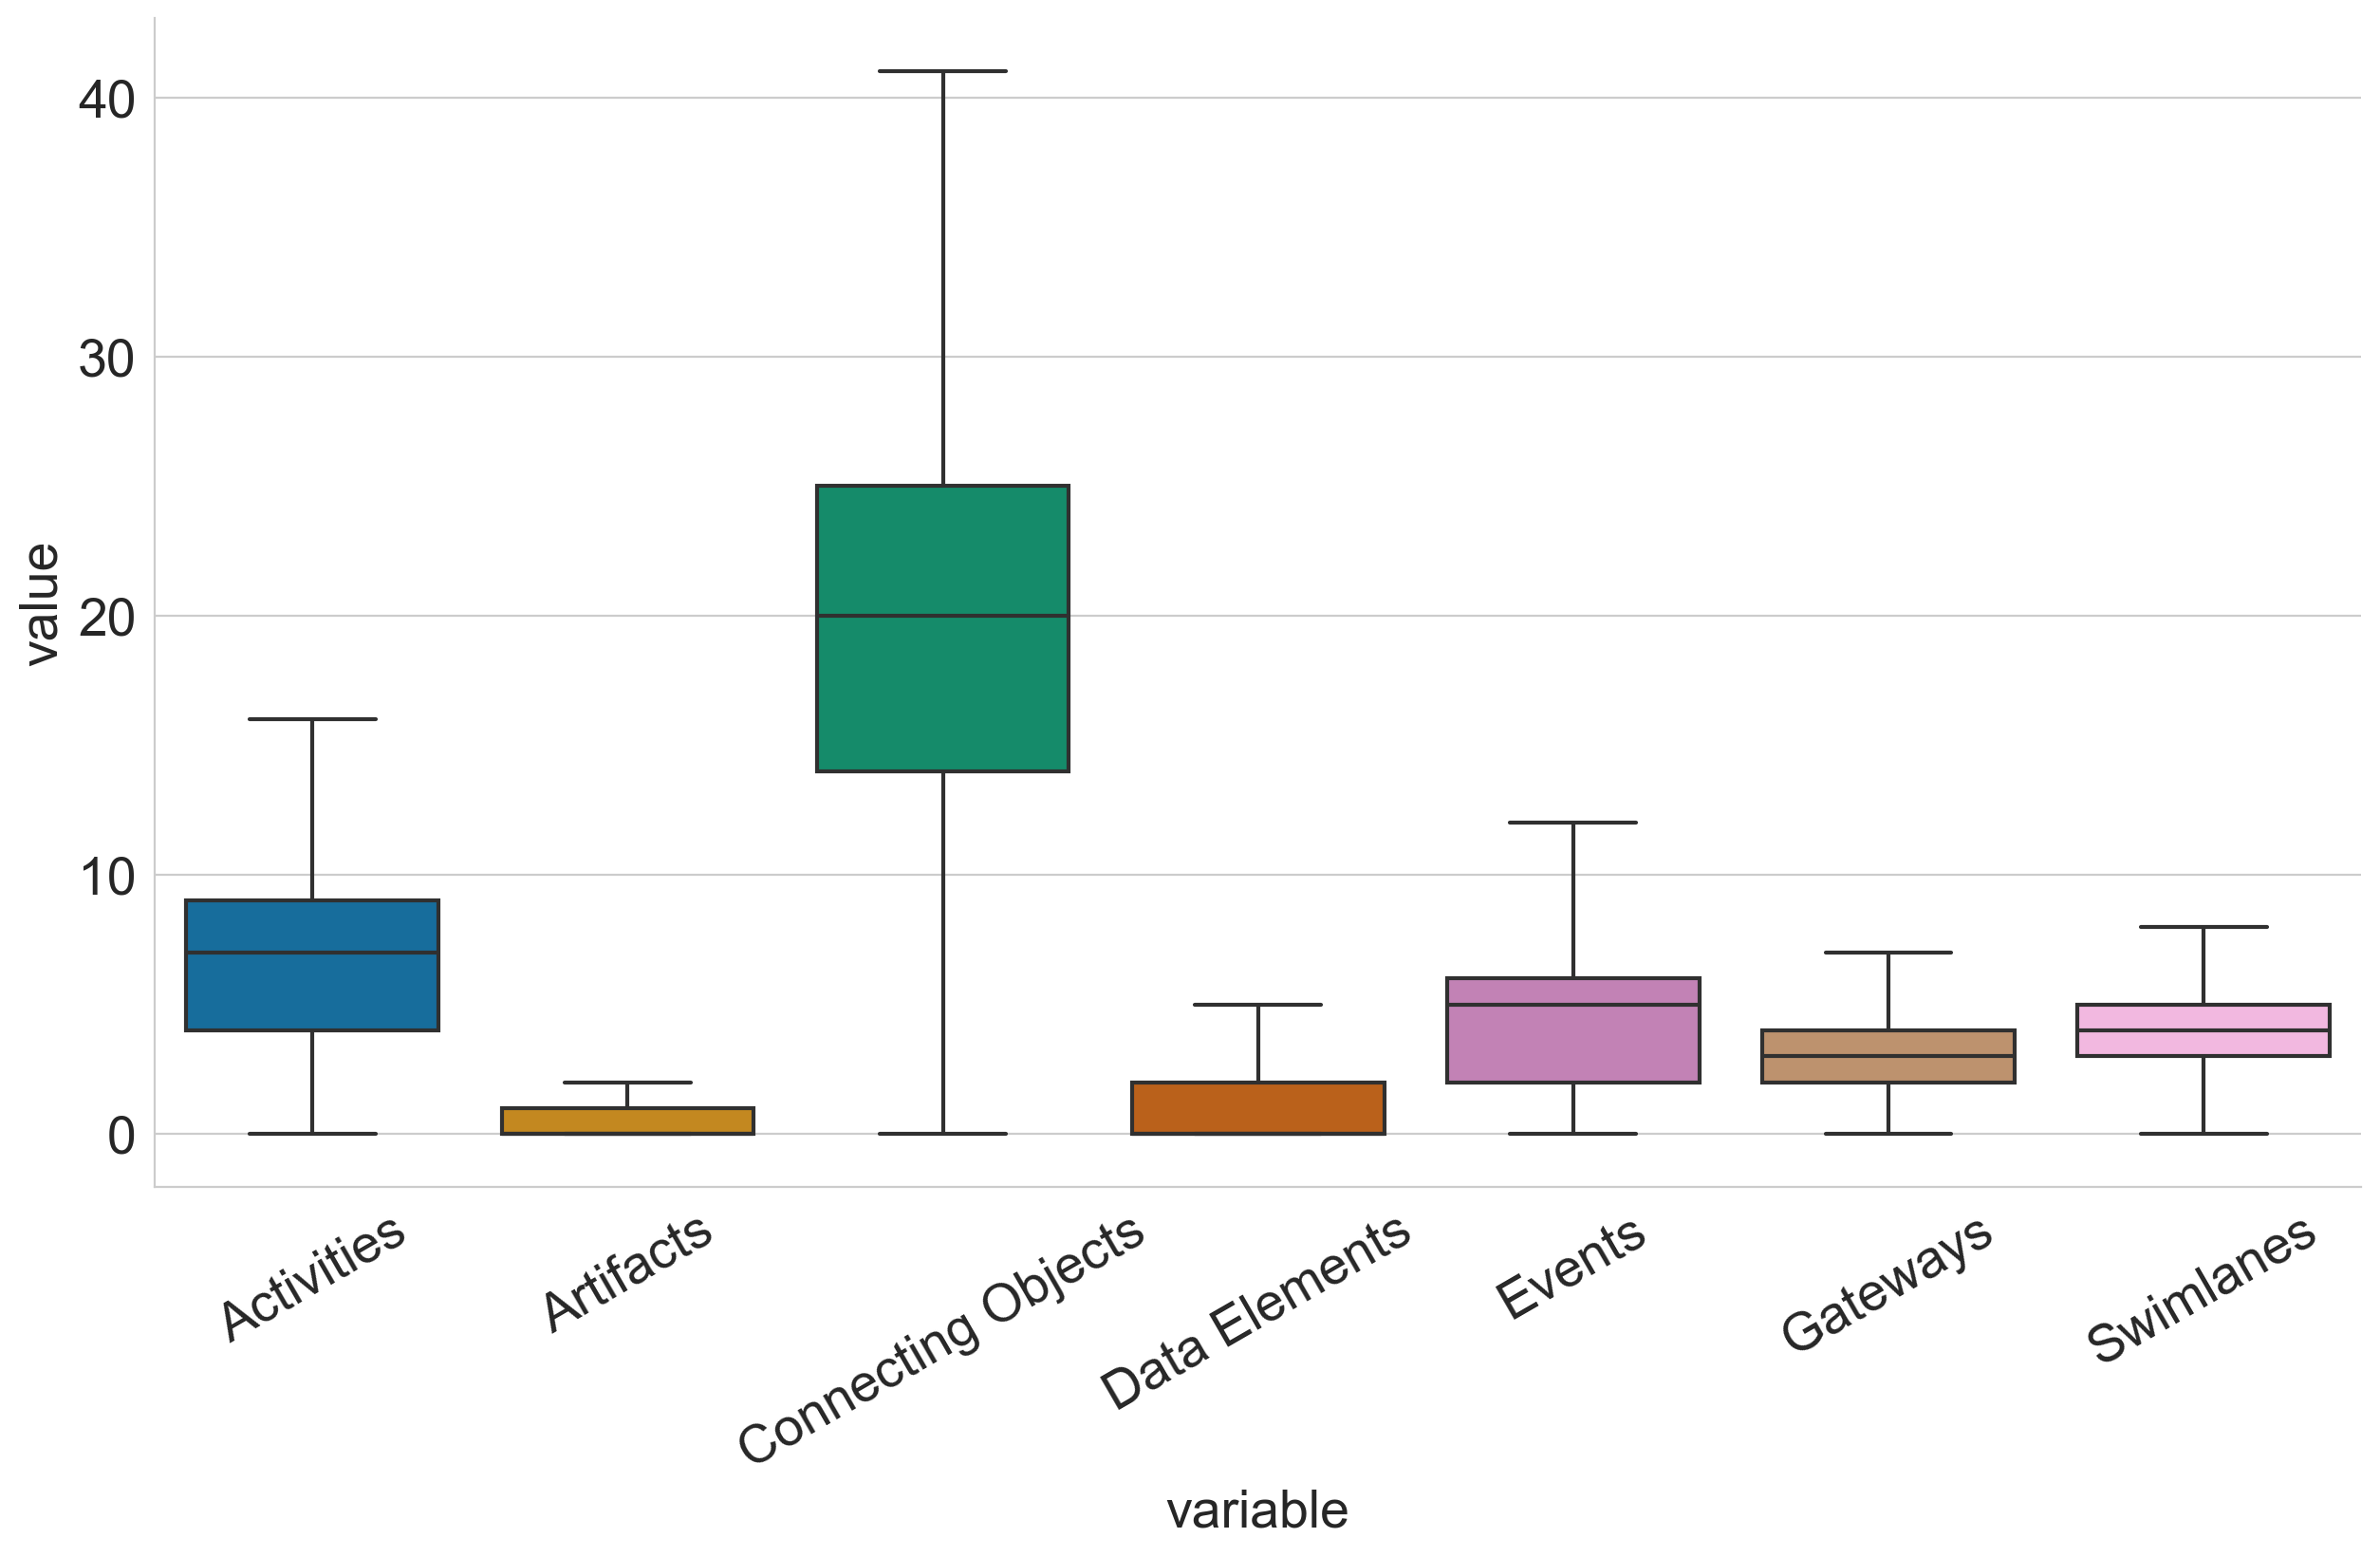

In [50]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind"))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [51]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

count       mean        std  min   25%   50%   75%    max
No. of Edges  12640.0  23.103877  21.338661  0.0  14.0  20.0  25.0  709.0
No. of Nodes  12640.0  23.556646  19.502028  0.0  16.0  20.0  24.0  624.0

In [52]:
df_high_level.head()

No. of Edges  No. of Nodes
0             3             9
1            25            22
2            17            21
3             6             7
4            29            37

The number of nodes and edges is naturally highly correlated:

<Figure size 500x500 with 0 Axes>

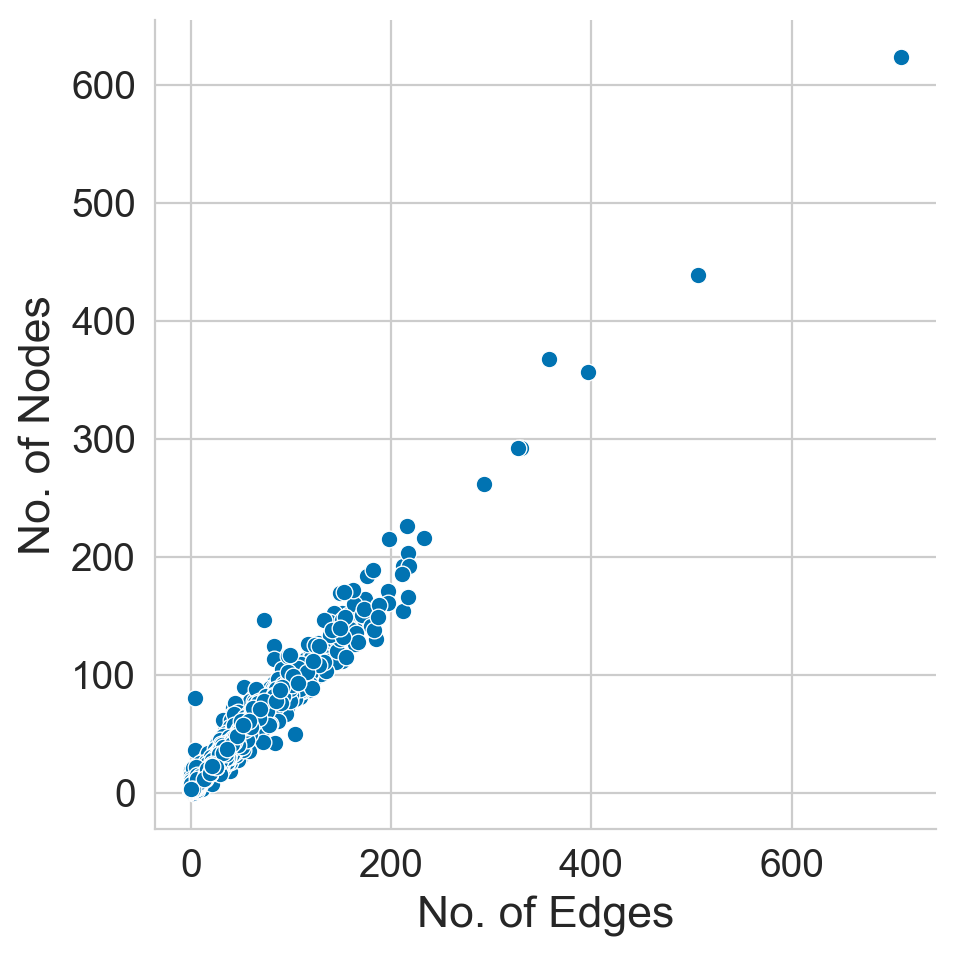

In [53]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [54]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [55]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

name  occurrences
0         12345678          472
1      New Process          301
2    Neuer Prozess          111
3    12345678_rev1           46
4    12345678_rev2           33
5         Jane Doe           27
6    12345678_rev3           26
7             BPMN           21
8  New Value Chain           18
9             test           17

The number of distinct process names:

In [56]:
len(cnts_names)

9531

We use Signavio's color palette for the word cloud.

In [57]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

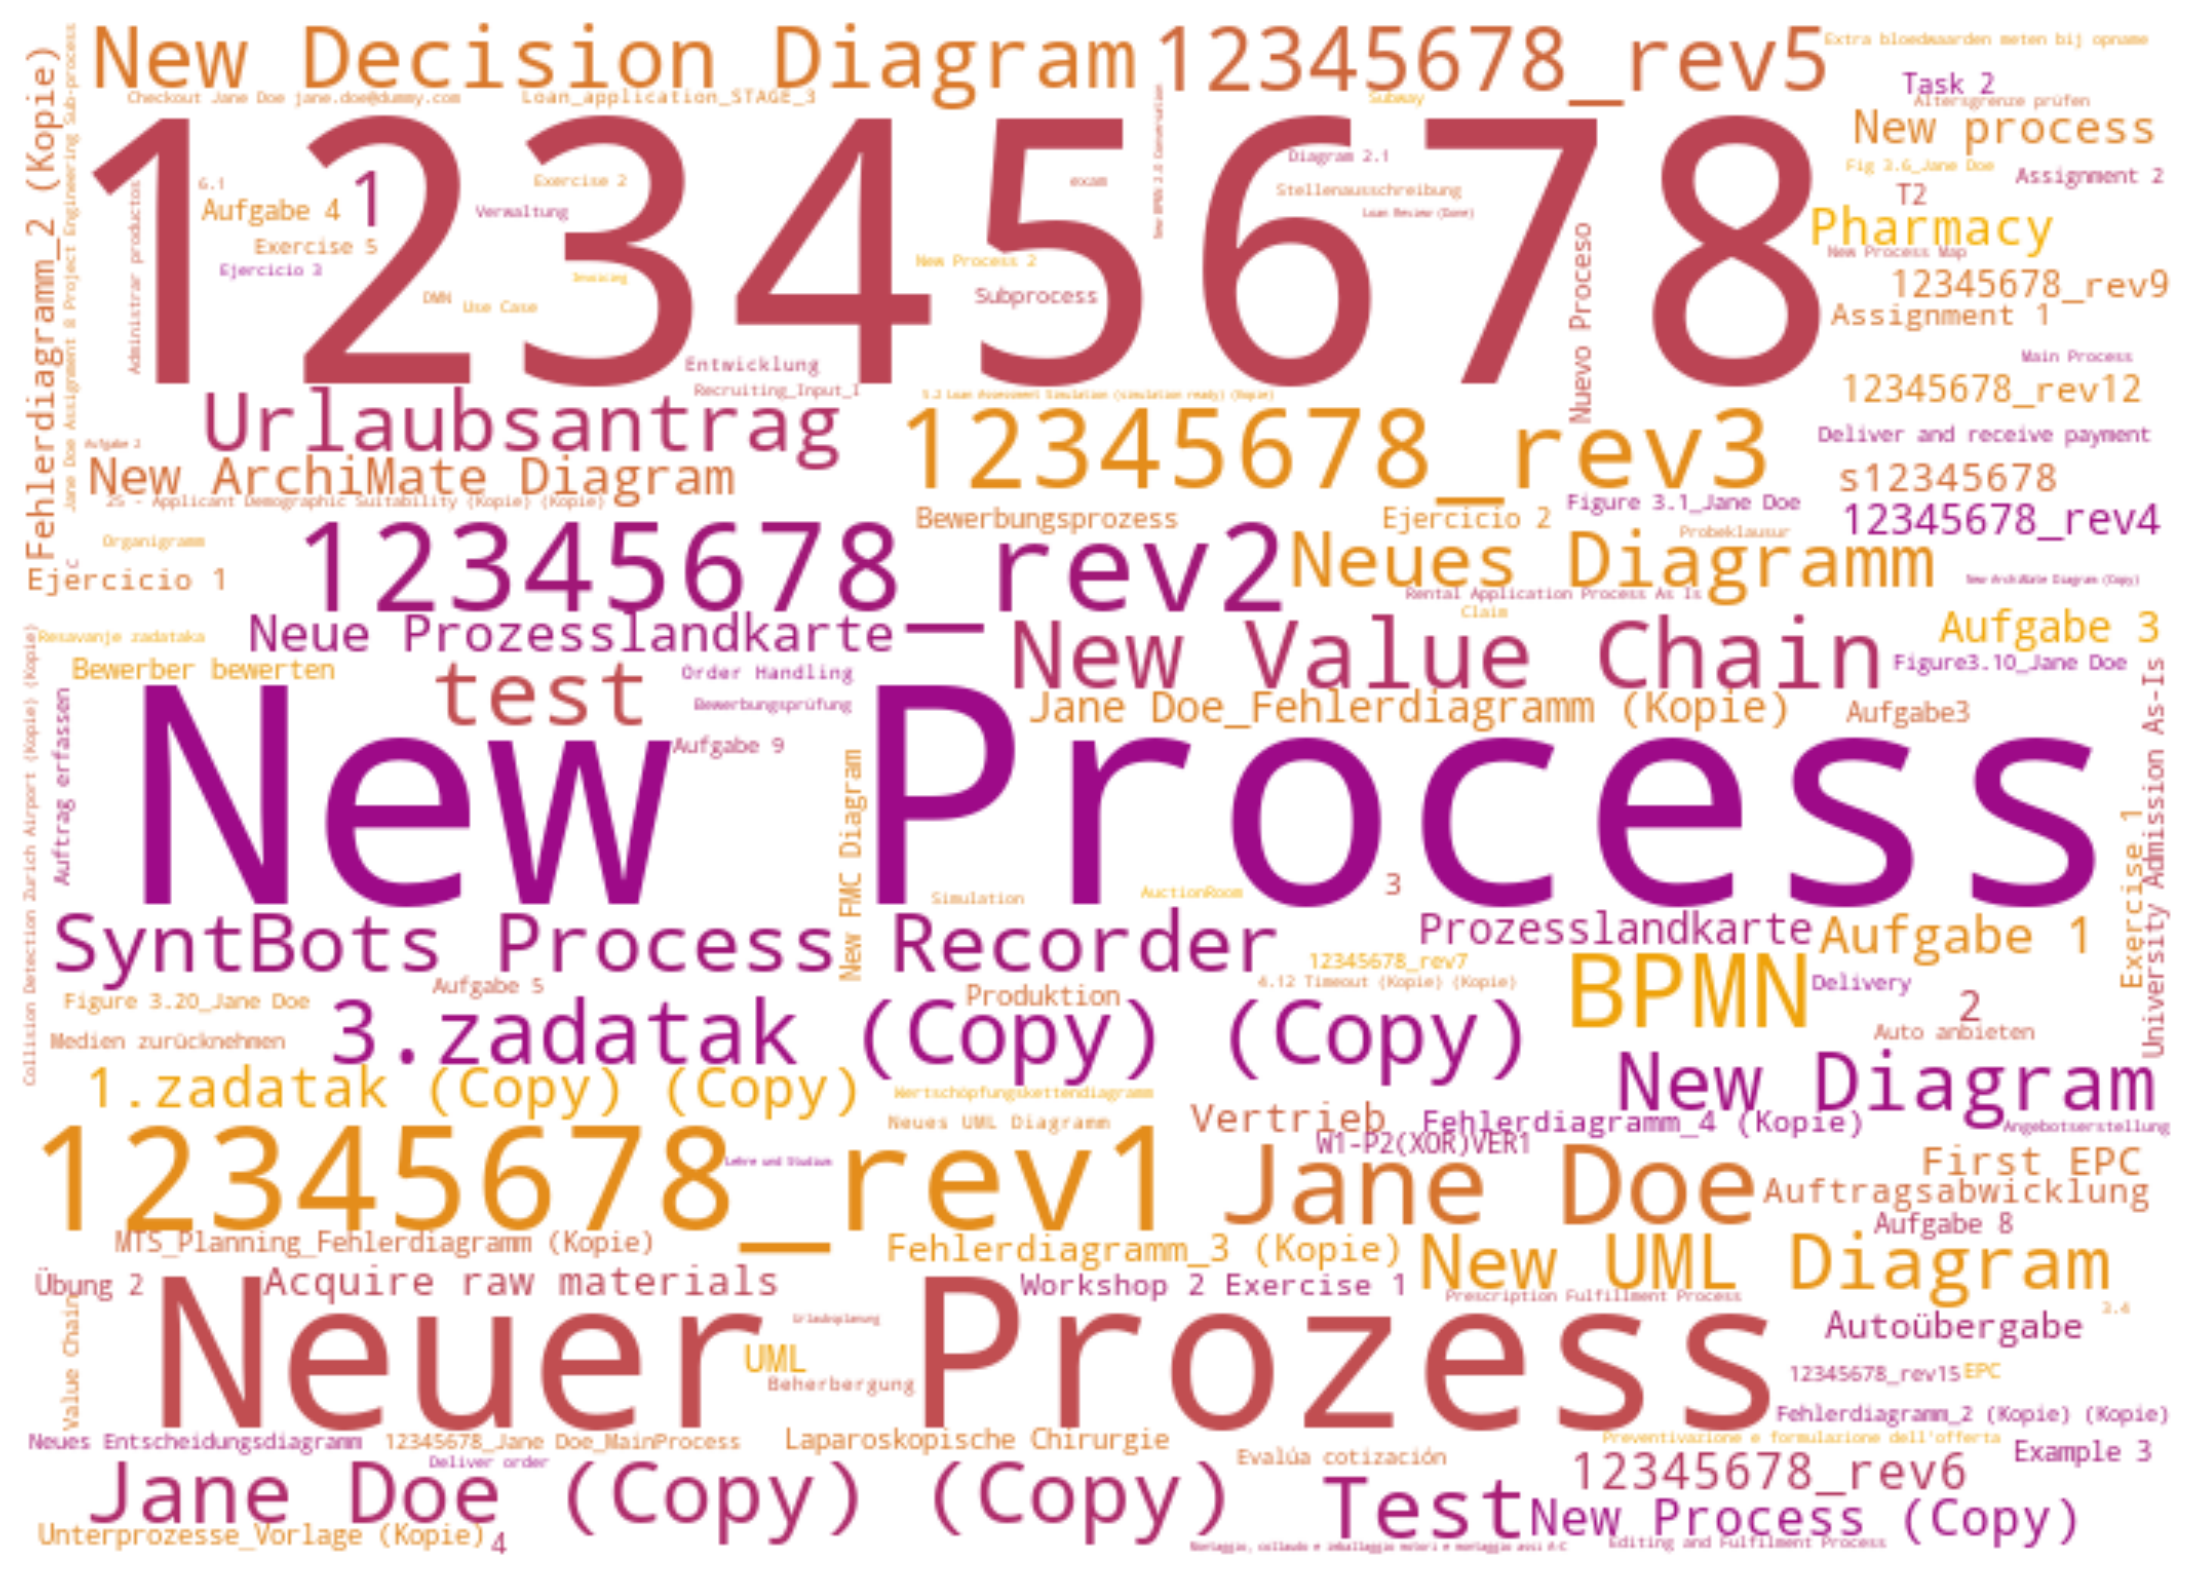

In [58]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [59]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

label  occurrences
0                     ACME AG         4559
1                          No         3714
2                         Yes         3285
3                  ERP-System         2907
4                    Supplier         2109
5                          no         1600
6                         yes         1453
7  Human Resources Department         1360
8                 Procurement         1344
9              Work equipment         1324

The number of distinct element labels:

In [60]:
len(cnts_labels)

125184

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [61]:
len(df_bpmn)

589816

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [62]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.5844051503350525

... while 64.9 % of the labels are used for only one element.

In [63]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.8537432898773006

In [64]:
len(cnts_labels[cnts_labels.occurrences==1])

106875

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [65]:
bins = cnts_labels
bins.head()

label  occurrences
0     ACME AG         4559
1          No         3714
2         Yes         3285
3  ERP-System         2907
4    Supplier         2109

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [66]:
N = 10000
bins = bins.groupby(bins.index // N).sum()

In [67]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

occurrences  bins of labels
0       161537           10000
1        18309           20000
2        10000           30000
3        10000           40000
4        10000           50000

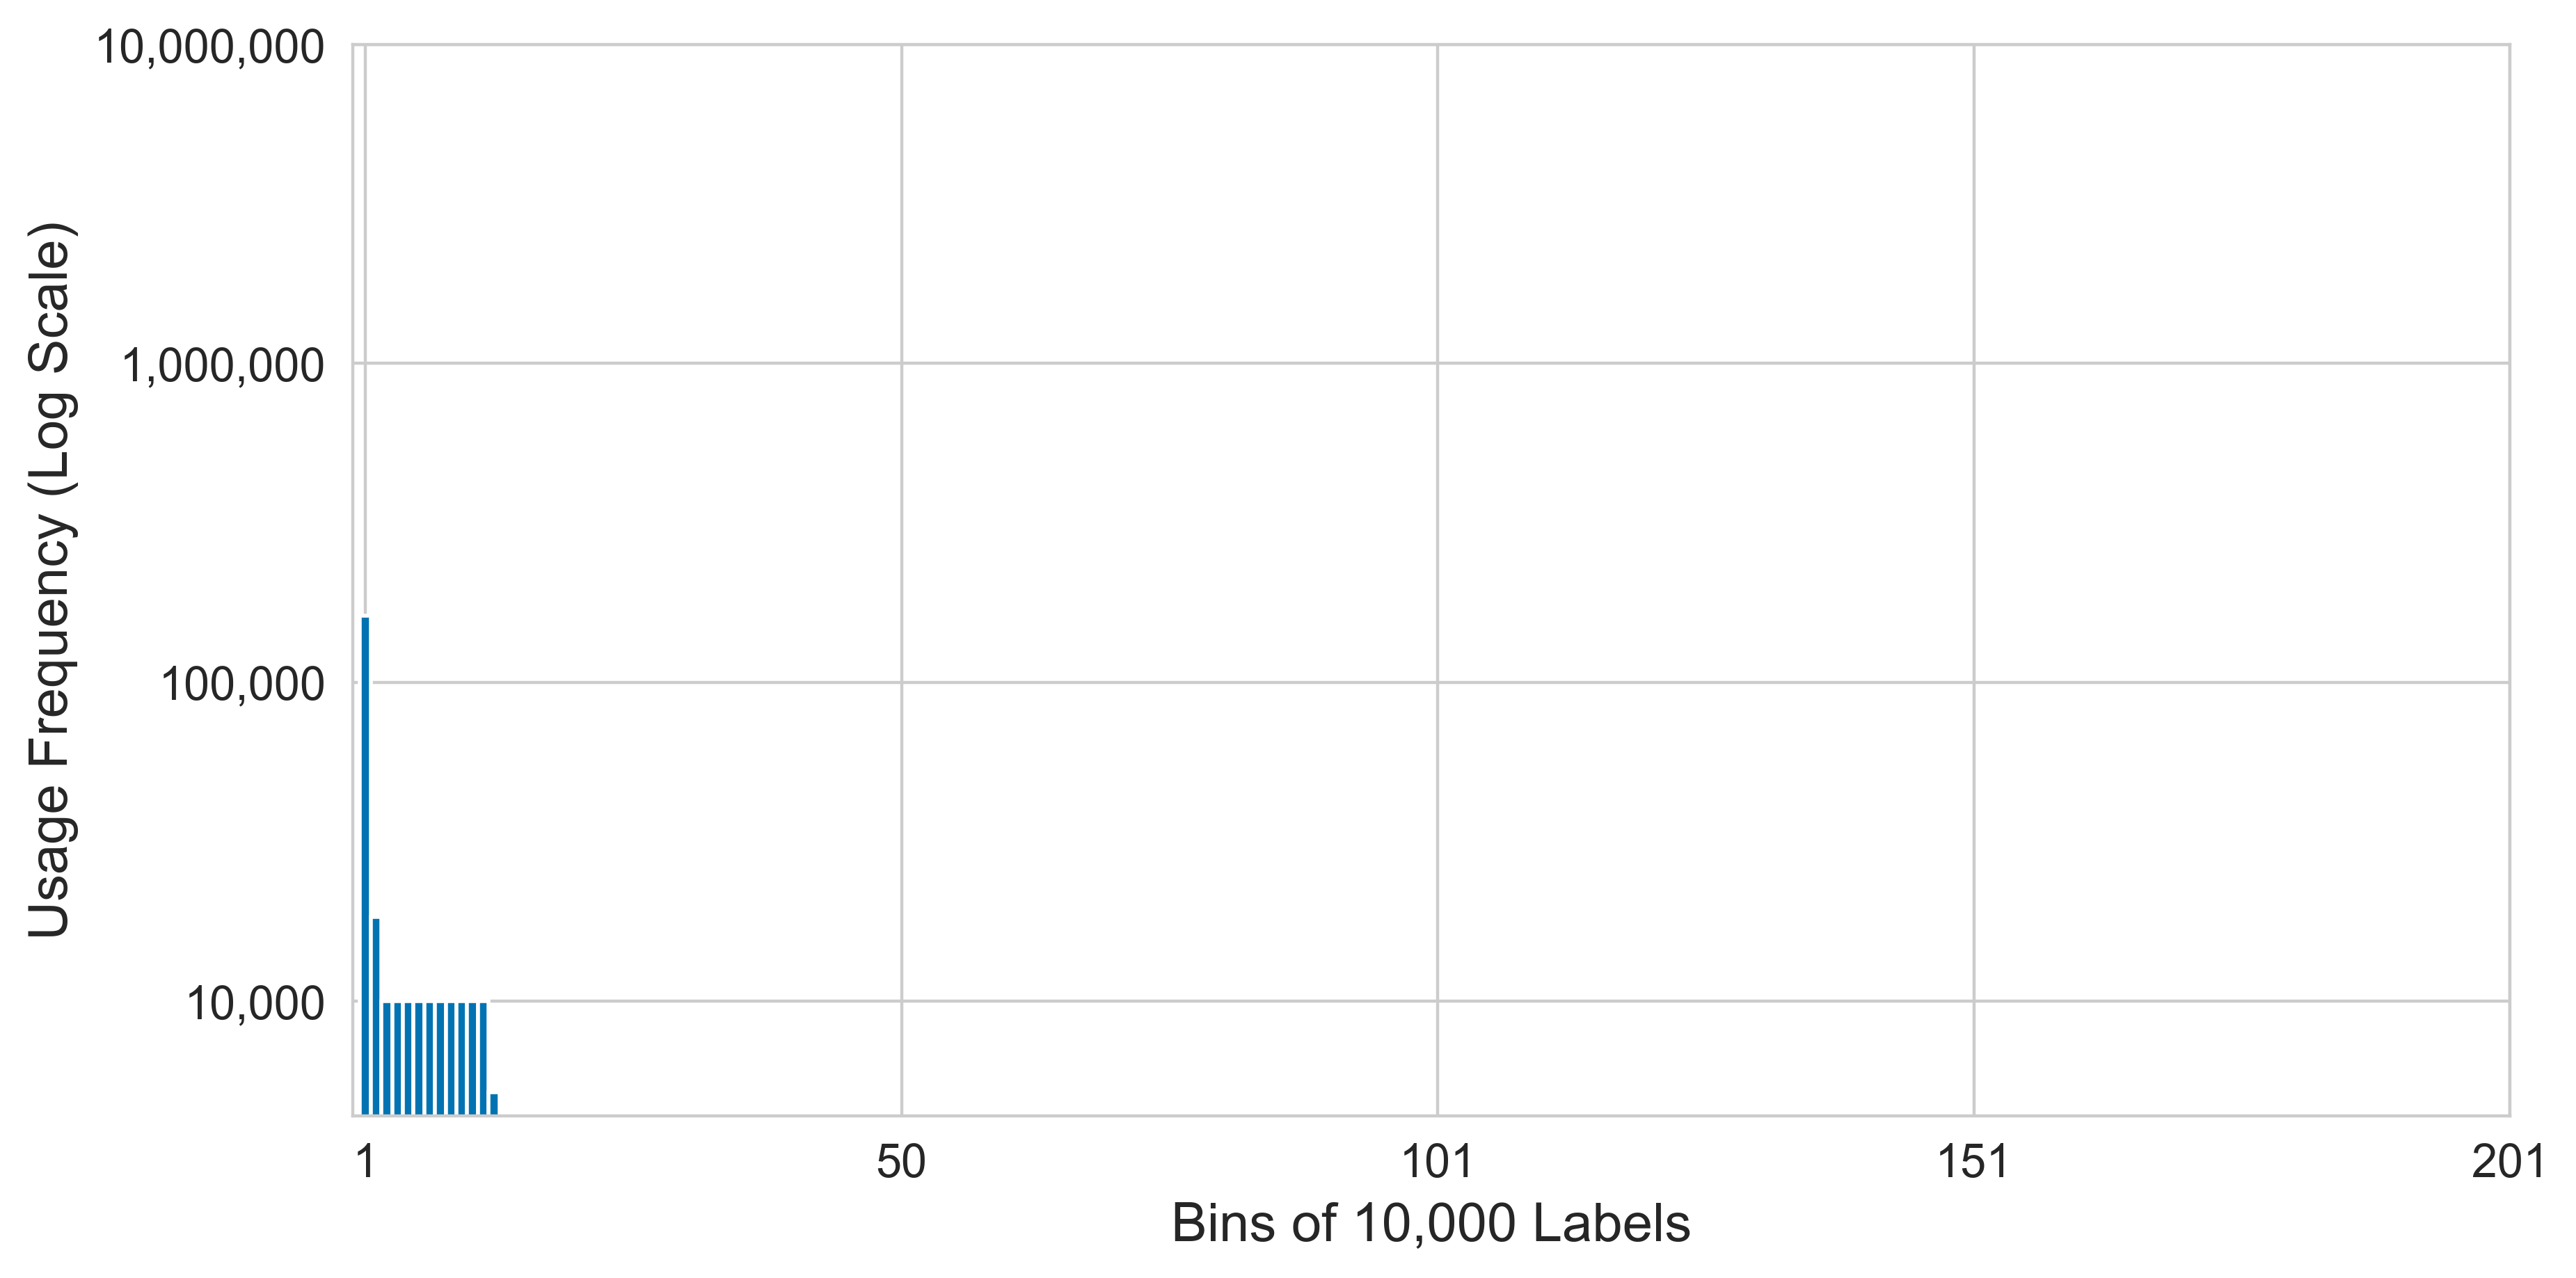

In [68]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

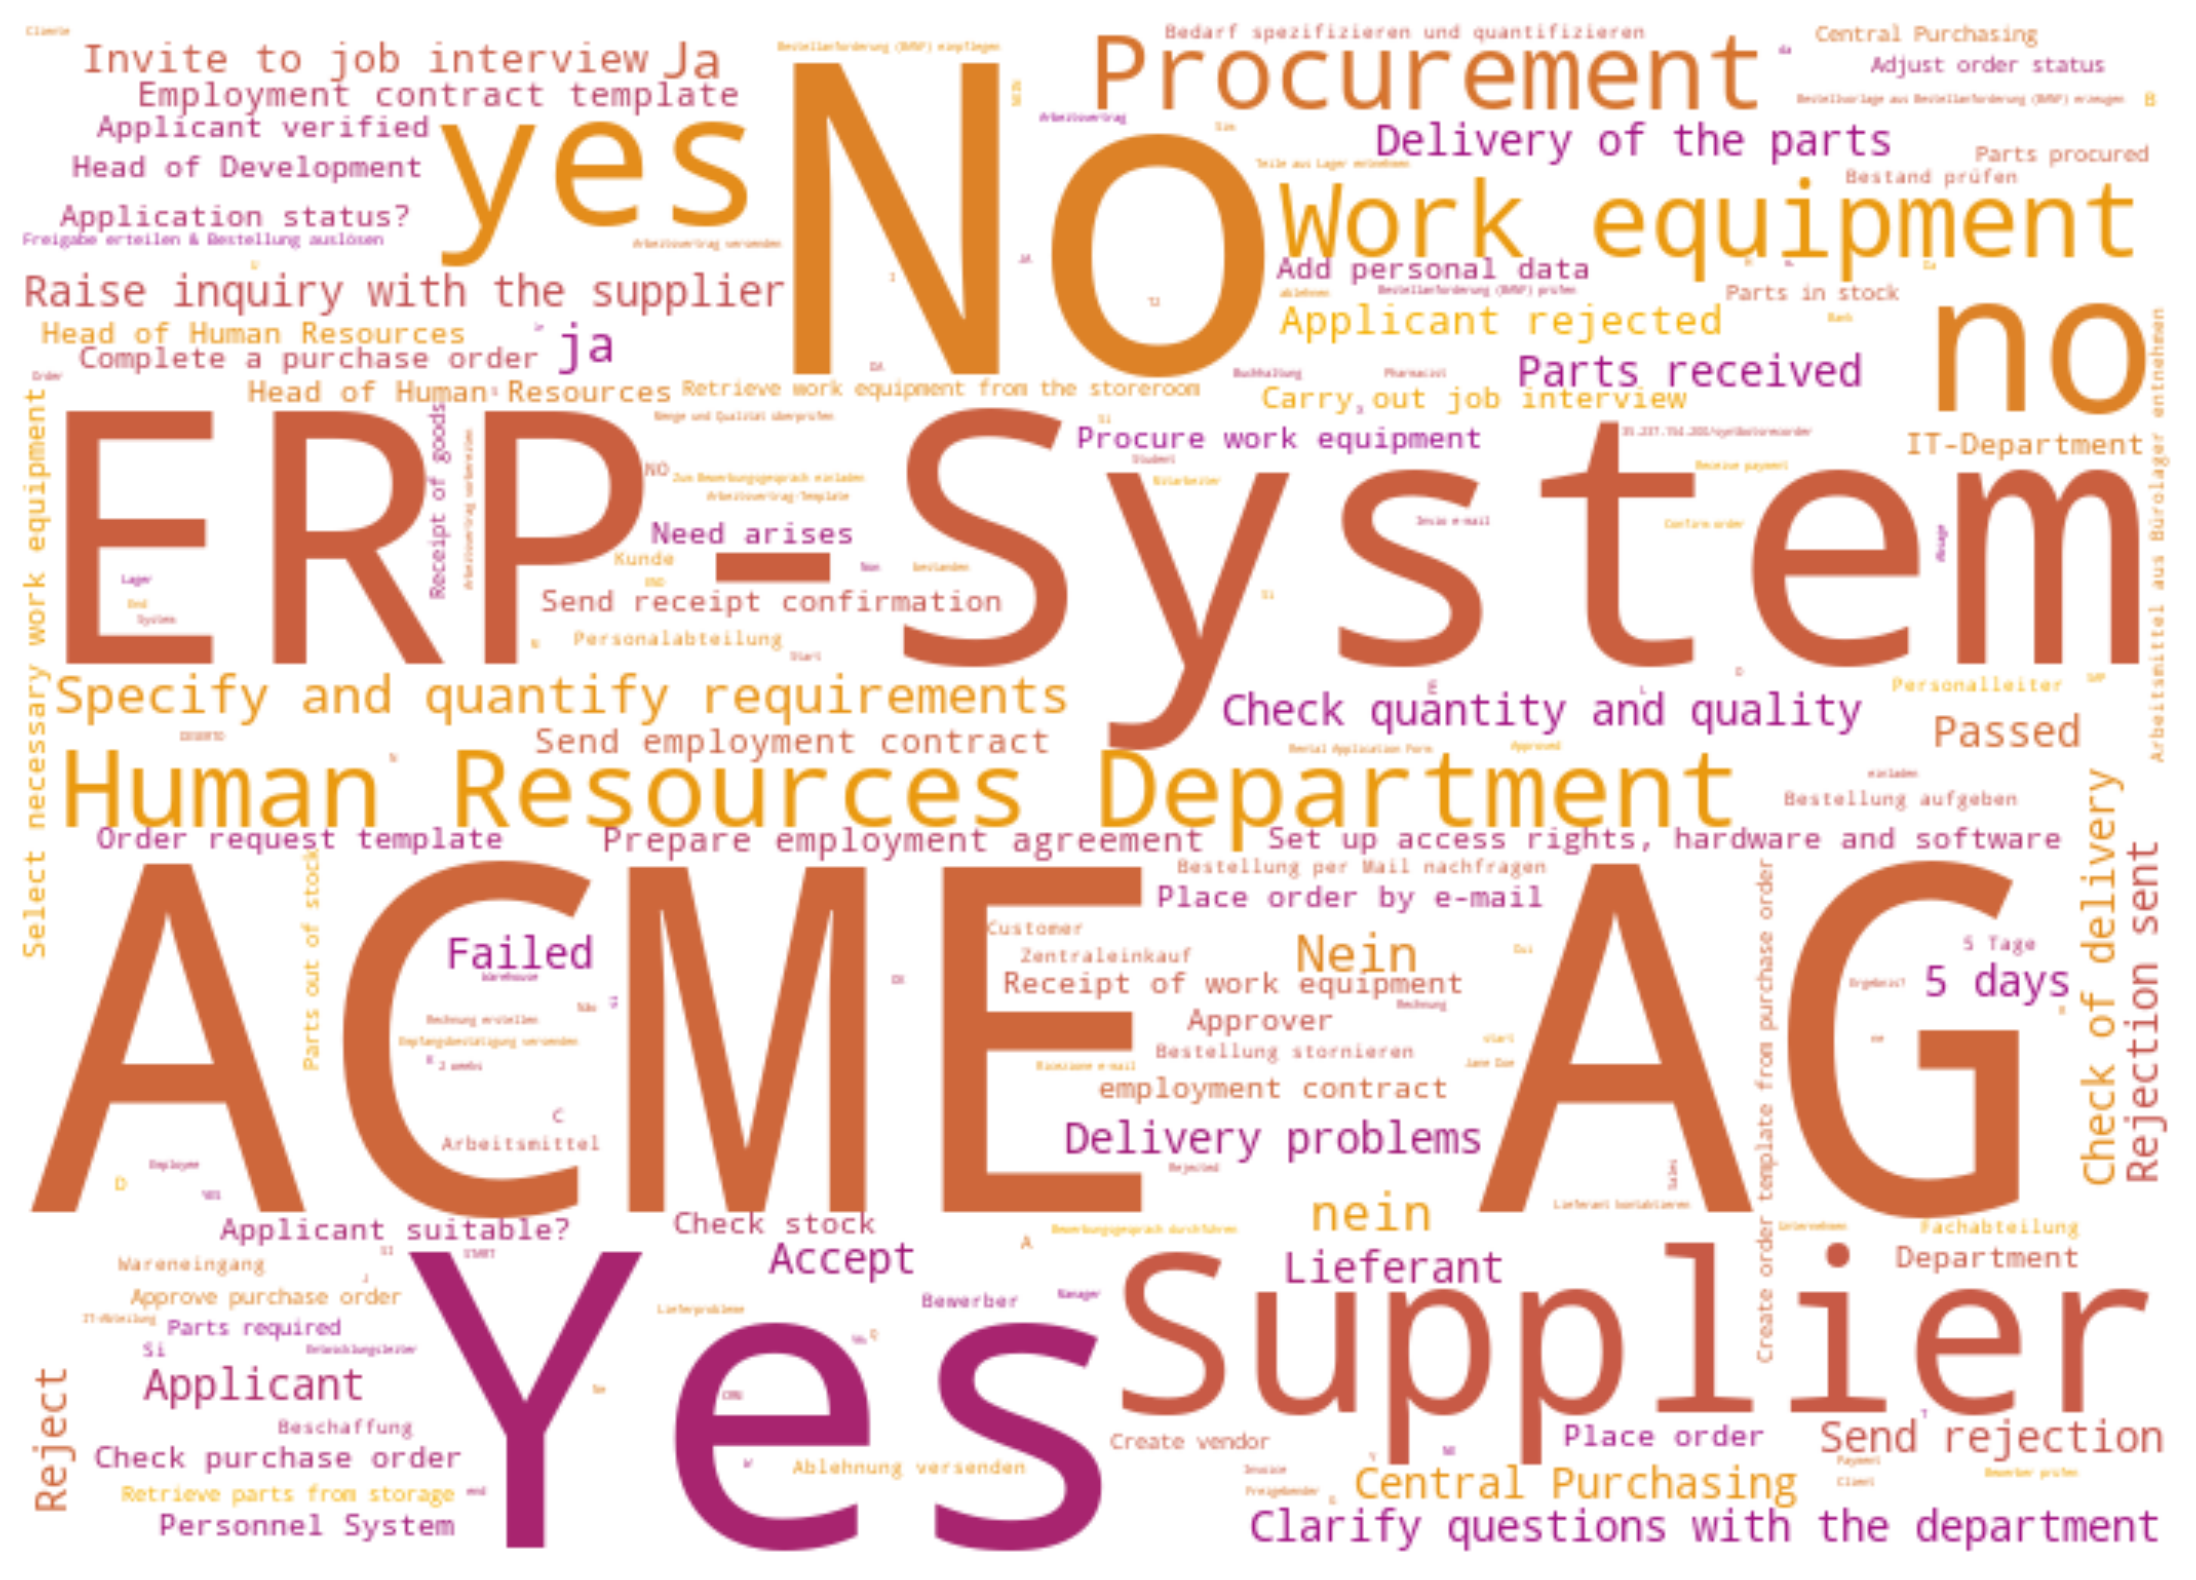

In [69]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()